In [1]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("max_colwidth", 200)

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import os.path
import fuzzywuzzy as fz
import googletrans as gtr
import translate as tr
import langdetect as ld
import scipy as sp

os.getcwd()

from hyperopt import hp

import optuna

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

from sklearn.dummy import DummyRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from numpy import asarray

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import datasets

import timeit

from sklearn import metrics

import shap
import lime.lime_tabular

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from sklearn import decomposition


In [2]:
# use module pylint to verify PEP8


In [3]:
# customers informations (keys : zip_code_prefix, customer_id):
df_customer = pd.read_csv('olist_customers_dataset.csv')

# geolocation informations (key : zip_code_prefix = geolocation_zip_code_prefix)
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')

# orders contents informations (commande) (key : order_id)
df_order_item = pd.read_csv('olist_order_items_dataset.csv')

# payments informations (key : order_id)
df_order_payment = pd.read_csv('olist_order_payments_dataset.csv')

# orders comments, reviews informations (key : order_id)
df_order_review = pd.read_csv('olist_order_reviews_dataset.csv')

# orders status informations (key : order_id, customer_id)
df_order_dataset = pd.read_csv('olist_orders_dataset.csv')

# products informations (key : product_id)
df_product = pd.read_csv('olist_products_dataset.csv')

# sellers informations (key : seller_id, zip_code_prefix = seller_zip_code_prefix)
df_seller = pd.read_csv('olist_sellers_dataset.csv')

# products category information (key : none)
df_product_cat_name = pd.read_csv('product_category_name_translation.csv')

In [4]:
# rename keys :

df_geolocation.rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix'},inplace=True)
df_seller.rename(columns={'seller_zip_code_prefix':'zip_code_prefix'},inplace=True)
df_customer.rename(columns={'customer_zip_code_prefix':'zip_code_prefix'},inplace=True)

In [5]:
df_order_item[df_order_item['order_id']=='1b15974a0141d54e36626dca3fdc731a'].tail(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11950,1b15974a0141d54e36626dca3fdc731a,19,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11951,1b15974a0141d54e36626dca3fdc731a,20,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12


In [6]:
# group dataset df_order_item by order_id :

d_O_ID = {'order_item_id':'first','price':'sum','freight_value':'sum','product_id':'first'}

order_id_gby = (df_order_item.groupby(['order_id'],sort=False,as_index=False).agg(d_O_ID).reindex(columns=df_order_item.columns))

In [139]:
df_customer

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [8]:
df_product

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [9]:
df_order_review

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,"Solicitei a compra de uma capa de retrovisor celta/prisma/meriva - preta - lado esquerdo, mas chegou para mim uma capa do lado direito de outro modelo de carro.\r\nEstou decepcionado! Fico no agua...",2017-12-15 00:00:00,2017-12-16 01:29:43


In [10]:
df_product_cat_name

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


# Exploratory analysis

## Analyse des notes

In [11]:
df_order_review.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

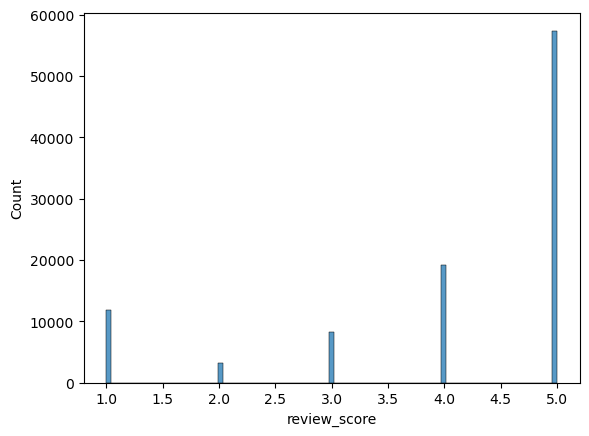

In [12]:
sns.histplot(data=df_order_review, x="review_score")
plt.show()

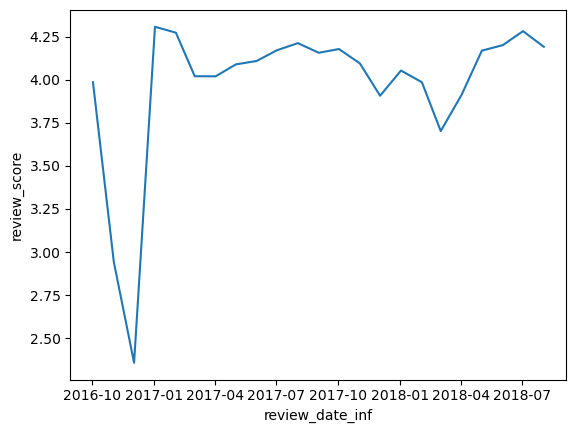

In [13]:
# ajouter l'évolution dans le temps

  ## mise en forme des colonnes de dates :
    
df_order_review['review_date']=df_order_review['review_creation_date'].astype(str).str[:10]

df_order_review['review_date_2'] = pd.to_datetime(df_order_review['review_date'],format='%Y-%m-%d')

df_order_review.head(1)

import datetime
import dateutil.relativedelta

date_mois=[]

for i in range(0,24):

    d = datetime.datetime.strptime("2016-10-02", "%Y-%m-%d")
    d2 = d + dateutil.relativedelta.relativedelta(months=i)
    date_mois.append(d2)
    
date_mois

    ## calcul de la moyenne des notes sur un mois


list_min=[]


for i in df_order_review['review_date_2']:
    x = min(date_mois, key=lambda x:abs(x-i))
    if x <= i :
        mini = x
        maxi = x + dateutil.relativedelta.relativedelta(months=1)
        list_min.append(mini)

    elif x > i :
        maxi = x
        mini = x - dateutil.relativedelta.relativedelta(months=1)
        list_min.append(mini)

        

df_order_review['review_date_inf']=list_min
#df_order_review['review_date_sup']=liste_max

d_OR={'review_score':'mean'}
df_order_review_gby = (df_order_review.groupby(['review_date_inf'],sort=True,as_index=False).agg(d_OR).reindex(columns=df_order_review.columns))
df_order_review_gby
sns.lineplot(data=df_order_review_gby, x="review_date_inf",y='review_score' )
plt.show()



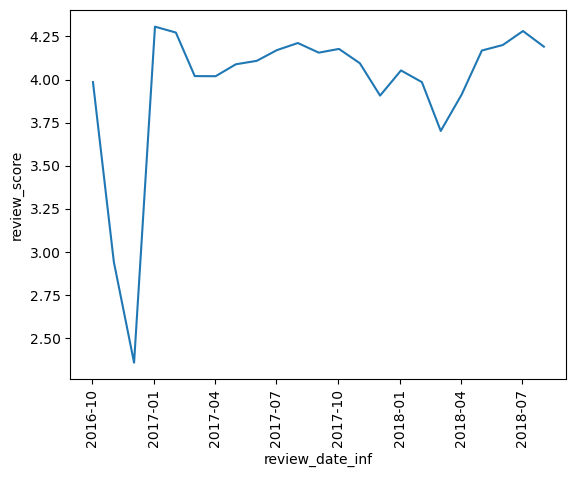

In [14]:
sns.lineplot(data=df_order_review_gby, x="review_date_inf",y='review_score' )
plt.xticks(rotation = 'vertical')
plt.show()

In [15]:
# what happened in december 2016 ?

filter_1 = df_order_review[df_order_review['review_date_inf']<'2017-01-02']
filter_2 = filter_1[filter_1['review_date_inf']>='2016-12-02']

filter_2.head(5)


# clearly, it seems that there was a problem about days of livraison. We'll verify that later.

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_date,review_date_2,review_date_inf
68,6d06808638ec0701bccd70bc8d462c28,97d2f8fe76f2f253b8291e17b5383884,1,NaN,"O produto não chegou no prazo estipulado e causou transtorno, pq programei a viagem de férias do meu filho, baseado no prazo. Moro na Bahia e ele em Cuiabá sozinho. Agora, a casa está vazia.",2016-12-09 00:00:00,2016-12-19 14:10:43,2016-12-09,2016-12-09,2016-12-02
6815,9190e6754710d977b6bc3185688e3ffe,7d7bf3ee337c36ce012762da5f28f53a,1,NaN,"Um absurdo um cliente se sujeitar a um prazo de entrega demasiadamente prolongado e ainda assim, não receber o produto.",2016-12-03 00:00:00,2016-12-06 14:46:16,2016-12-03,2016-12-03,2016-12-02
7399,8757f5e0a1f891b890039b0d95c321c8,4551b488487e6cfa31f9e35073d3c5d4,1,NaN,"Fiquei muito chateada pois deixei de comprar de outro vendedor e depois de muitos dias recebi um email informando que o produto não poderia ser entregue, comprar e não receber é muito chato.",2016-12-09 00:00:00,2016-12-09 11:16:13,2016-12-09,2016-12-09,2016-12-02
10828,d7486b4da781b9d7dc5484ce65868081,45973912e490866800c0aea8f63099c8,1,NaN,Atrasos acontecem nenhuma empresa está livre de passar por algum problema de logística. Mas o fato de não comunicarem seu cliente final é vergonhoso. Até o Mercado Livre tem controle sobre atrasos!,2016-12-03 00:00:00,2016-12-05 10:33:35,2016-12-03,2016-12-03,2016-12-02
11213,73a800e5d1c124670b154a46582477c7,de8f4a82099fe4fa6bcb8952ca51420f,5,NaN,amei super recomendo chega muito rapido e em ótimo estado amei,2016-12-16 00:00:00,2017-01-13 17:34:52,2016-12-16,2016-12-16,2016-12-02


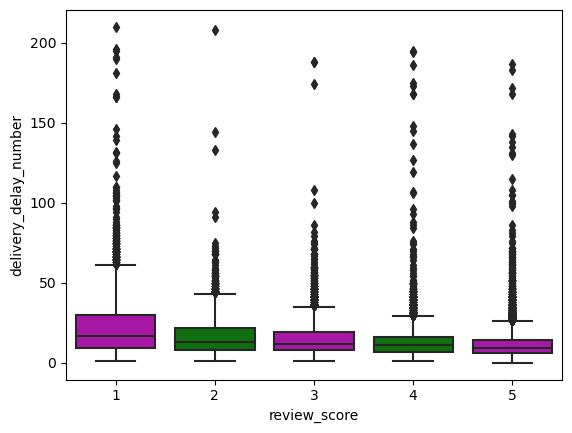

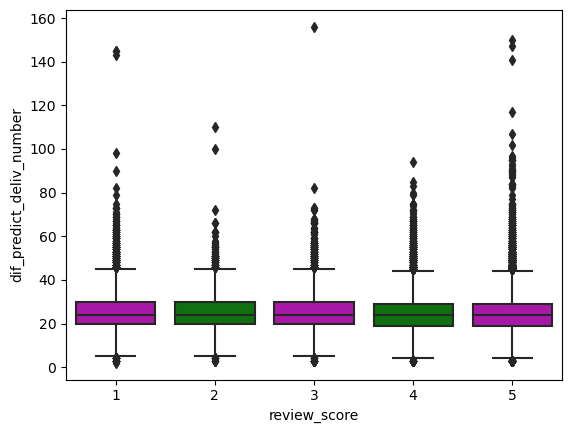

In [16]:
# merge two datasets and analyse correlation between review score and delivery delay :

df_orders_review_score = pd.merge(df_order_dataset,df_order_review,on='order_id',how='left')
    
    ## time between purchase and delivery :

df_orders_review_score['order_delivered_customer_date_2'] = df_orders_review_score['order_delivered_customer_date'].astype(str).str[:10]
df_orders_review_score['order_delivered_customer_date_3'] = pd.to_datetime(df_orders_review_score['order_delivered_customer_date_2'],format='%Y-%m-%d')

df_orders_review_score['order_purchase_timestamp_2'] = df_orders_review_score['order_purchase_timestamp'].astype(str).str[:10]
df_orders_review_score['order_purchase_timestamp_3'] = pd.to_datetime(df_orders_review_score['order_purchase_timestamp_2'],format='%Y-%m-%d')


df_orders_review_score['order_estimated_delivery_date_2'] = df_orders_review_score['order_estimated_delivery_date'].astype(str).str[:10]
df_orders_review_score['order_estimated_delivery_date_3'] = pd.to_datetime(df_orders_review_score['order_estimated_delivery_date_2'],format='%Y-%m-%d')


df_orders_review_score['order_purchase_timestamp_2'] = df_orders_review_score['order_purchase_timestamp'].astype(str).str[:10]
df_orders_review_score['order_purchase_timestamp_3'] = pd.to_datetime(df_orders_review_score['order_purchase_timestamp_2'],format='%Y-%m-%d')




df_orders_review_score['delivery_delay'] = df_orders_review_score['order_delivered_customer_date_3']-df_orders_review_score['order_purchase_timestamp_3']

df_orders_review_score['delivery_delay_number'] = df_orders_review_score.delivery_delay.dt.days

df_orders_review_score['dif_predict_deliv'] = df_orders_review_score['order_estimated_delivery_date_3']-df_orders_review_score['order_purchase_timestamp_3']

df_orders_review_score['dif_predict_deliv_number'] = df_orders_review_score.dif_predict_deliv.dt.days


yk=[1,2,3,4,5]

sns.boxplot(x='review_score',y='delivery_delay_number',palette=["m", "g"],order=yk,
            data=df_orders_review_score)

plt.show()

sns.boxplot(x='review_score',y='dif_predict_deliv_number',palette=["m", "g"],order=yk,
            data=df_orders_review_score)

plt.show()



## Moyens de paiement

In [17]:
df_order_payment.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

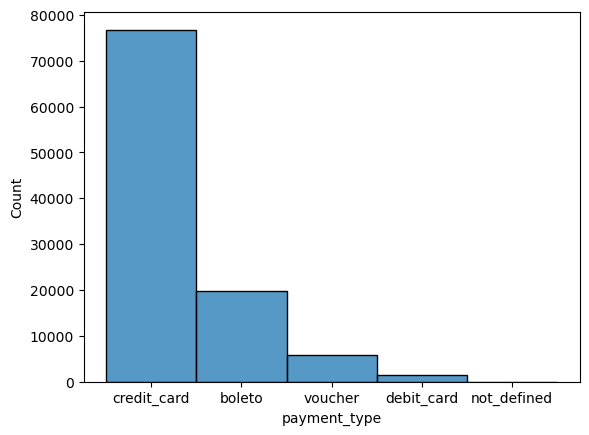

In [18]:
sns.histplot(data=df_order_payment, x="payment_type")
plt.show()

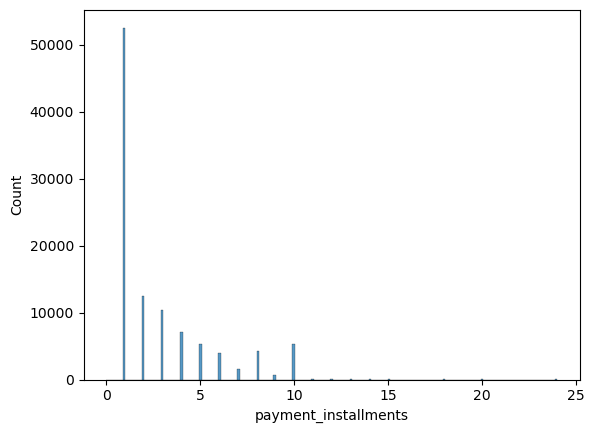

In [19]:
sns.histplot(data=df_order_payment, x="payment_installments")
plt.show()

## Analyse de l'évolution des volumes d'achat

In [20]:
df_order_item.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [21]:
order_id_gby

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,NaN,NaN,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,NaN,NaN,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,NaN,NaN,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,NaN,NaN,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,NaN,NaN,199.90,18.14
...,...,...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,NaN,NaN,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,NaN,NaN,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,NaN,NaN,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,NaN,NaN,55.99,8.72


In [22]:
# merge previous dataset with order_id_bgy (=order_id_item groupby order_id )

df_100 = pd.merge(order_id_gby,df_orders_review_score,on='order_id',how='left')
df_100['total_price']=df_100['price']+df_100['freight_value']
df_100.head(1)

 ## same logical as previously with review scores to cluster by dates :
    
date_mois_2=[]

for i in range(0,24):

    d = datetime.datetime.strptime("2016-09-04", "%Y-%m-%d")
    d2 = d + dateutil.relativedelta.relativedelta(months=i)
    date_mois_2.append(d2)
    
date_mois_2

list_min_2=[]

for i in df_100['order_purchase_timestamp_3']:
    x = min(date_mois_2, key=lambda x:abs(x-i))
    if x <= i :
        mini = x
        list_min_2.append(mini)
        #liste_max.append(maxi)
    elif x > i :
        mini = x - dateutil.relativedelta.relativedelta(months=1)
        list_min_2.append(mini)    

        
 ## evolution of payment :



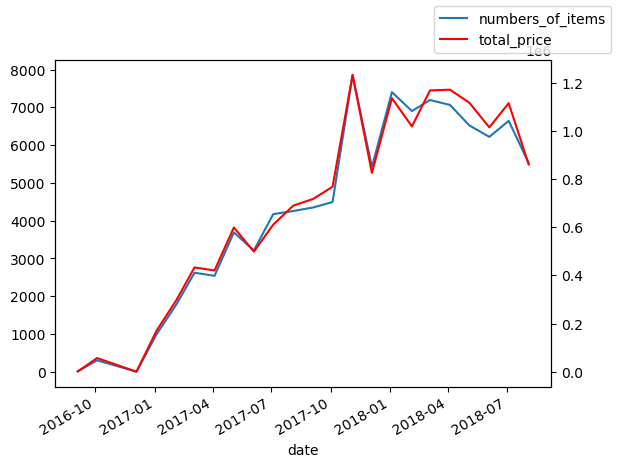

In [23]:
df_100['order_purchase_timestamp_3_min'] = list_min_2

d_1000 = {'order_item_id':'sum','total_price':'sum'}
df_1000 = (df_100.groupby(['order_purchase_timestamp_3_min'],sort=True,as_index=False).agg(d_1000).reindex(columns=df_100.columns))
df_1000.rename(columns={'order_item_id':'numbers_of_items'}, inplace=True)
df_1000.rename(columns={'order_purchase_timestamp_3_min':'date'}, inplace=True)


ax = df_1000.plot(x="date", y="numbers_of_items", legend=False)
ax2 = ax.twinx()
df_1000.plot(x="date", y="total_price", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [24]:
df_100.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_date,review_date_2,review_date_inf,order_delivered_customer_date_2,order_delivered_customer_date_3,order_purchase_timestamp_2,order_purchase_timestamp_3,order_estimated_delivery_date_2,order_estimated_delivery_date_3,delivery_delay,delivery_delay_number,dif_predict_deliv,dif_predict_deliv_number,total_price,order_purchase_timestamp_3_min
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,NaN,NaN,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,2017-09-21,2017-09-21,2017-09-02,2017-09-20,2017-09-20,2017-09-13,2017-09-13,2017-09-29,2017-09-29,7 days,7.0,16 days,16,72.19,2017-09-04
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,NaN,NaN,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,2017-05-13,2017-05-13,2017-05-02,2017-05-12,2017-05-12,2017-04-26,2017-04-26,2017-05-15,2017-05-15,16 days,16.0,19 days,19,259.83,2017-04-04


## Analyse des notes en fonction des catégories d'article :

In [25]:
df_order_review.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_date,review_date_2,review_date_inf
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2018-01-18,2018-01-18,2018-01-02
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,2018-03-10,2018-03-10,2018-03-02


In [26]:
doubles = df_order_review['order_id'].value_counts().rename_axis('unique_value').to_frame('counts')
doubles.head(10)

,counts
unique_value,
03c939fd7fd3b38f8485a0f95798f1f6,3
c88b1d1b157a9999ce368f218a407141,3
df56136b8031ecd28e200bb18e6ddb2e,3
8e17072ec97ce29f0e1f111e598b0c85,3
171c9f9a5667b0bea55d8b78c27bc5bd,2
1a69d5fdff0003d4571dffa1a9a10967,2
3ba42e1ab3dfab510424d0872616a139,2
4464462d945bc41b8b7cc74d04722969,2
566f53fc7d36fa366f7e221468121877,2


In [27]:
df_order_review[df_order_review['order_id']=='0d6cc2219ef268358eac3c49b47abca9']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_date,review_date_2,review_date_inf
18655,1ce9388b1a3ad76f5f1a64f208a90fce,0d6cc2219ef268358eac3c49b47abca9,1,NaN,O prazo era até dia 23/03 e até o momento não recebi. Quero saber o que está acontecendo.,2018-03-25 00:00:00,2018-03-25 21:40:11,2018-03-25,2018-03-25,2018-03-02
36800,5ac791169055b4994a395a442e3956f6,0d6cc2219ef268358eac3c49b47abca9,1,NaN,"Comprei pensando que ia vir conforme a foto, vel branco e a parte baixo bege, porém veio tudo bege.",2018-03-23 00:00:00,2018-03-24 12:57:14,2018-03-23,2018-03-23,2018-03-02


In [28]:
# on ne sait pas sur quel produit a été laissé l'avis. On fait l'hypothèse que l'avis est laissé sur l'item 1.

In [29]:
# joindre notre database avec df_product (on product_id) puis df_product_cat_name (on product_category_name)

In [149]:
df_200 = pd.merge(df_100,df_product,on='product_id',how='left')
df_300 = pd.merge(df_200,df_product_cat_name,on='product_category_name',how='left')

df_score_customer = df_300[['order_id','review_score','customer_id','delivery_delay_number']]

df_score_customer_2 = pd.merge(df_score_customer,df_customer,on='customer_id',how='left')

df_score_customer_unique = df_score_customer_2[['order_id','review_score','customer_unique_id','delivery_delay_number']]

df_score_customer_unique.isna().sum()



order_id                    0
review_score                0
customer_unique_id          0
delivery_delay_number    2209
dtype: int64

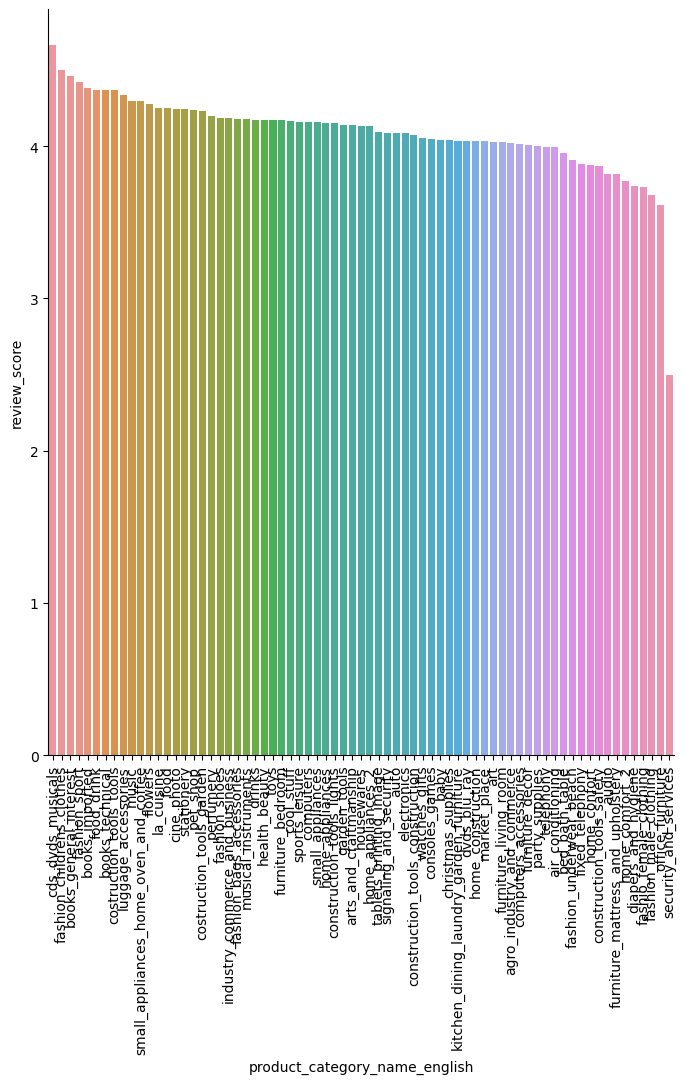

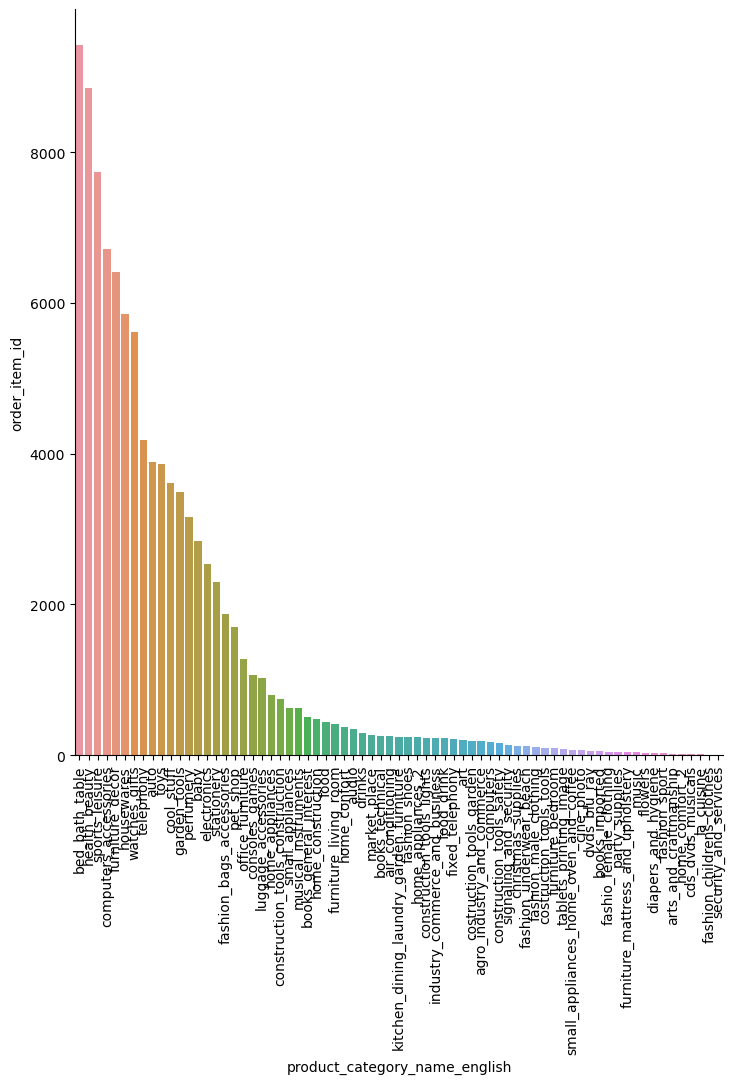

In [31]:
note=[1,2,3,4,5]


d_500={'review_score':'mean','order_item_id':'sum'}
df_500 = (df_300.groupby(['product_category_name_english'],sort=True,as_index=False).agg(d_500).reindex(columns=df_300.columns))

df_500 = df_500.sort_values(by=['review_score'],ascending=False)

sns.catplot(data=df_500, x='product_category_name_english',y='review_score',kind="bar",height=8)
plt.xticks(rotation = 'vertical')

plt.show()


df_500 = df_500.sort_values(by=['order_item_id'],ascending=False)


sns.catplot(data=df_500, x='product_category_name_english',y='order_item_id',kind="bar",height=8)
plt.xticks(rotation = 'vertical')

plt.show()    
    
    

## Nan :

In [32]:
# Nans : 

list_name_df=['df_customer','df_geolocation','df_order_item','df_order_payment','df_order_review','df_order_dataset','df_product','df_seller','df_product_cat_name']

list_df=[df_customer,df_geolocation,df_order_item,df_order_payment,df_order_review,df_order_dataset,df_product,df_seller,df_product_cat_name]

i=0
for df in list_df:
    print(list_name_df[i])
    print(df.shape)
    print(df.isna().sum())
    print("")
    i=i+1

df_customer
(99441, 5)
customer_id           0
customer_unique_id    0
zip_code_prefix       0
customer_city         0
customer_state        0
dtype: int64

df_geolocation
(1000163, 5)
zip_code_prefix      0
geolocation_lat      0
geolocation_lng      0
geolocation_city     0
geolocation_state    0
dtype: int64

df_order_item
(112650, 7)
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

df_order_payment
(103886, 5)
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

df_order_review
(100000, 10)
review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
review_date                    0
revie

In [33]:
# describe :

i=0
for df in list_df:
    print(list_name_df[i])
    print(df.describe())
    print("")
    i=i+1

df_customer
       zip_code_prefix
count     99441.000000
mean      35137.474583
std       29797.938996
min        1003.000000
25%       11347.000000
50%       24416.000000
75%       58900.000000
max       99990.000000

df_geolocation
       zip_code_prefix  geolocation_lat  geolocation_lng
count     1.000163e+06     1.000163e+06     1.000163e+06
mean      3.657417e+04    -2.117615e+01    -4.639054e+01
std       3.054934e+04     5.715866e+00     4.269748e+00
min       1.001000e+03    -3.660537e+01    -1.014668e+02
25%       1.107500e+04    -2.360355e+01    -4.857317e+01
50%       2.653000e+04    -2.291938e+01    -4.663788e+01
75%       6.350400e+04    -1.997962e+01    -4.376771e+01
max       9.999000e+04     4.506593e+01     1.211054e+02

df_order_item
       order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.8500

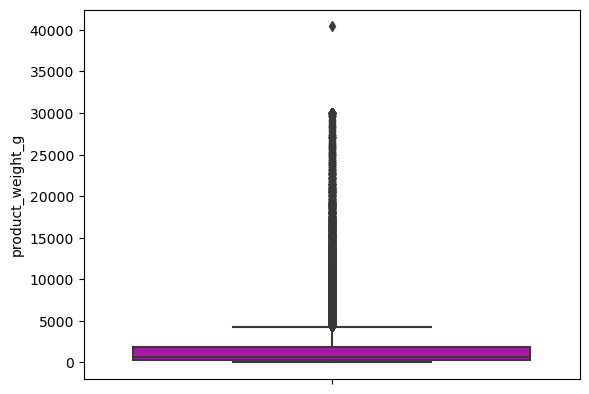

In [34]:
# outliers :

sns.boxplot(y='product_weight_g',palette=["m", "g"],
            data=df_product)
plt.show()

In [35]:
# kick only one outlier

df_product=df_product[df_product['product_weight_g']<35000]

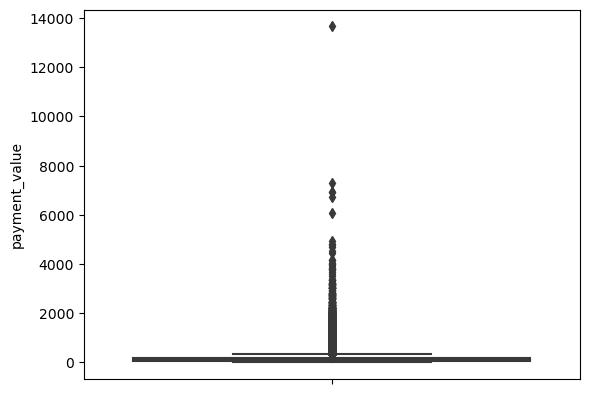

In [36]:
sns.boxplot(y='payment_value',palette=["m", "g"],
            data=df_order_payment)
plt.show()

In [37]:
# payments may be reals, but we kick outliers for our study (only 25 values to kick)

df_order_payment=df_order_payment[df_order_payment['payment_value']<3500]

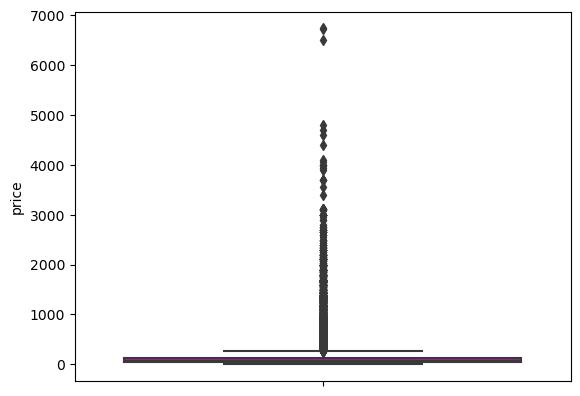

In [38]:

sns.boxplot(y='price',palette=["m", "g"],
            data=df_order_item)
plt.show()

In [39]:
# could be real orders, but only 58 values. Preferable to have a clean and uniform database

df_order_item=df_order_item[df_order_item['price']<2500]

In [40]:
list(df_customer.columns)

['customer_id',
 'customer_unique_id',
 'zip_code_prefix',
 'customer_city',
 'customer_state']

In [41]:
# Duplicate values :

d_geo={'geolocation_lat':'mean','geolocation_lng':'mean','geolocation_city':'first','geolocation_state':'first'}
df_geolocation=(df_geolocation.groupby(['zip_code_prefix'],sort=False,as_index=False).agg(d_geo).reindex(columns=df_geolocation.columns))

df_order_item[df_order_item['order_id']=='e481f51cbdc54678b7cc49136f2d6af7']
#df_order_items

#df_order_payments[df_order_payments['order_id']=='e481f51cbdc54678b7cc49136f2d6af7']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
100785,e481f51cbdc54678b7cc49136f2d6af7,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72




list_name_df=['df_customer','df_geolocation','df_order_item','df_order_payment','df_order_review','df_order_dataset','df_product','df_seller','df_product_cat_name']

list_df=[df_customer,df_geolocation,df_order_item,df_order_payment,df_order_review,df_order_dataset,df_product,df_seller,df_product_cat_name]

i=0
for df in list_df:
    print(list_name_df[i])
    for col in list(df.columns):
        print(df[col].value_counts())
    
    print('')
    i=i+1
    
        


In [42]:
# correction of false duplicate value (ex : saô paulo vs. sao paulo)
# to avoid that, use the short names like SP for cities.

In [43]:
join=pd.merge(df_order_dataset,df_customer,on='customer_id',how='left')

In [44]:
join2=pd.merge(join,df_order_payment,on='order_id',how='left')

In [45]:
join3=pd.merge(join2,df_order_item,on='order_id',how='left')

In [46]:
join4=pd.merge(join3,df_product,on='product_id',how='left')

In [47]:
join5=pd.merge(join4,df_seller,on='seller_id',how='left')

In [48]:
join6=pd.merge(join5,df_product_cat_name,on='product_category_name',how='left')

In [49]:
df=join6

In [50]:
df.shape

(118433, 34)

In [51]:
df[df['order_id']=='83c1379a015df1e13d02aae0204711ab']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,zip_code_prefix_x,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,zip_code_prefix_y,seller_city,seller_state,product_category_name_english
118429,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,credit_card,5.0,271.01,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,eletrodomesticos_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0,8290.0,sao paulo,SP,home_appliances_2


In [52]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,zip_code_prefix_x,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,zip_code_prefix_y,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118428,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,credit_card,3.0,195.00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,bebes,52.0,828.0,4.0,4950.0,40.0,10.0,40.0,17602.0,tupa,SP,baby
118429,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,credit_card,5.0,271.01,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,eletrodomesticos_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0,8290.0,sao paulo,SP,home_appliances_2
118430,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00

In [53]:
df['product_category_name'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
118428    False
118429    False
118430    False
118431    False
118432    False
Name: product_category_name, Length: 118433, dtype: bool

In [54]:
df10=df.dropna(subset=['order_delivered_customer_date'],inplace=True)

In [55]:
df10=df.dropna(subset=['product_category_name'],inplace=True)

In [56]:
df10=df.dropna(subset=['order_approved_at'],inplace=True)

In [57]:
df10=df.dropna(subset=['payment_sequential'],inplace=True)

In [58]:
df10=df.dropna(subset=['order_delivered_carrier_date'],inplace=True)

In [59]:
df10=df.dropna(subset=['product_category_name_english'],inplace=True)

In [60]:
df.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
zip_code_prefix_x                0
customer_city                    0
customer_state                   0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm   

In [61]:
df.shape

(113283, 34)

In [62]:
to_drop=['order_status','order_purchase_timestamp','order_delivered_carrier_date',
         'order_delivered_customer_date','order_estimated_delivery_date','payment_sequential','shipping_limit_date','product_name_lenght','product_description_lenght',
         'product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_value']

In [63]:
df2=df.drop(to_drop,axis='columns')

In [64]:
df2['product_category_name_english'].value_counts()

bed_bath_table                             11646
health_beauty                               9755
sports_leisure                              8725
furniture_decor                             8553
computers_accessories                       7885
housewares                                  7171
watches_gifts                               6057
telephony                                   4601
garden_tools                                4457
auto                                        4283
toys                                        4185
cool_stuff                                  3901
perfumery                                   3480
baby                                        3108
electronics                                 2807
stationery                                  2564
fashion_bags_accessories                    2106
pet_shop                                    2005
office_furniture                            1753
luggage_accessories                         1148
consoles_games      

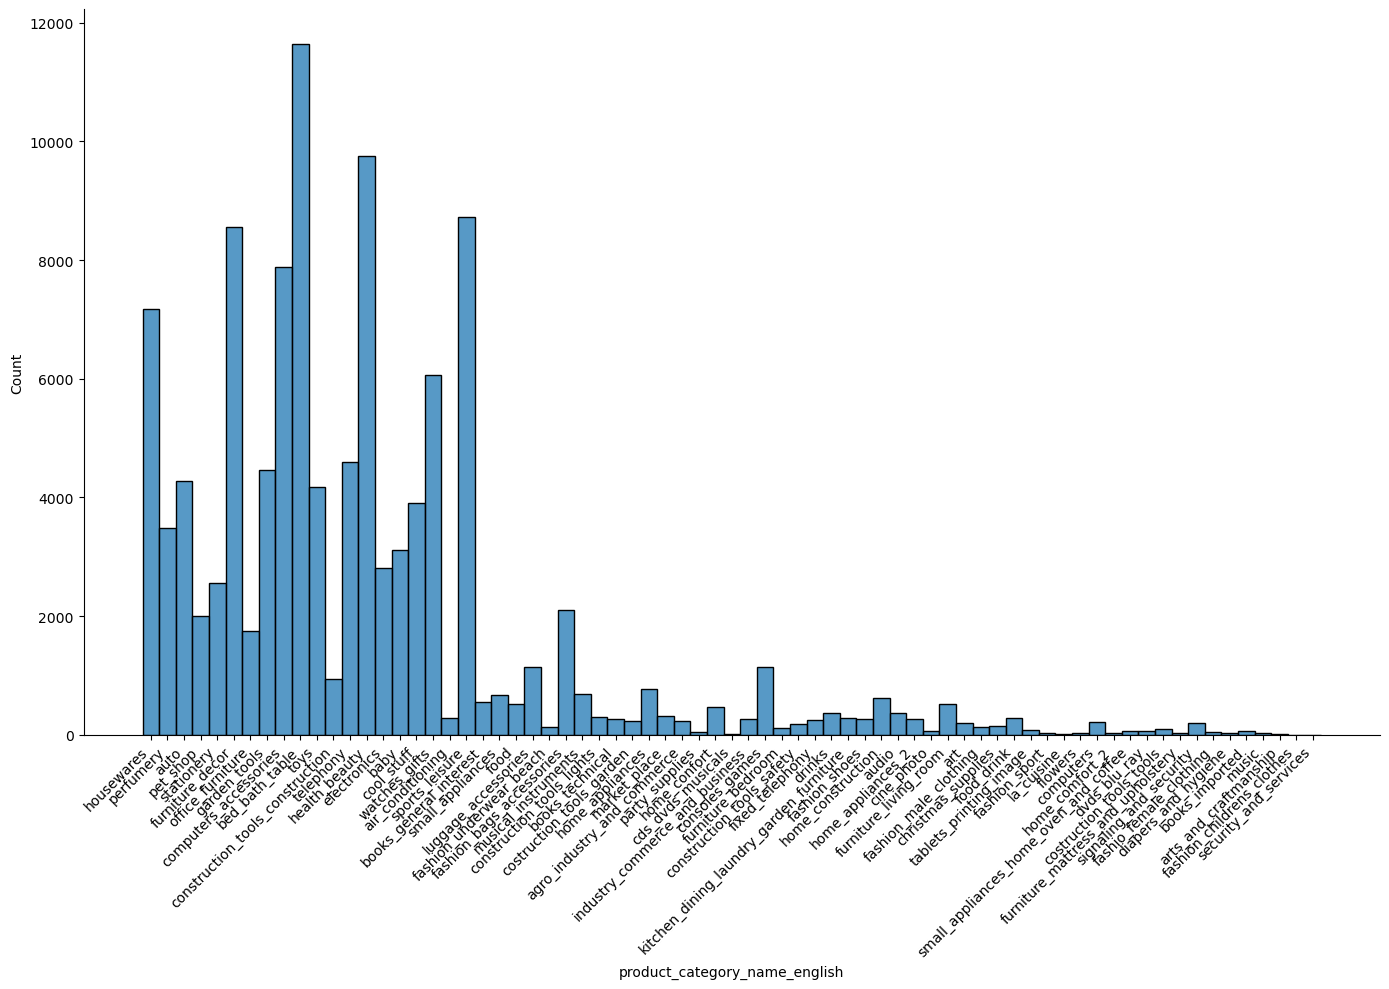

In [65]:
#sns.set(rc={'figure.figsize':(20,20)})

a=sns.displot(data=df2['product_category_name_english'],height=10, aspect=14/10)
a.set_xticklabels(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [66]:
df2['product_category_name_english'].value_counts()/len(df2['product_category_name_english'])


bed_bath_table                             0.102804
health_beauty                              0.086112
sports_leisure                             0.077019
furniture_decor                            0.075501
computers_accessories                      0.069604
housewares                                 0.063302
watches_gifts                              0.053468
telephony                                  0.040615
garden_tools                               0.039344
auto                                       0.037808
toys                                       0.036943
cool_stuff                                 0.034436
perfumery                                  0.030720
baby                                       0.027436
electronics                                0.024779
stationery                                 0.022634
fashion_bags_accessories                   0.018591
pet_shop                                   0.017699
office_furniture                           0.015475
luggage_acce

In [67]:
df2[df2['order_id']=='e481f51cbdc54678b7cc49136f2d6af7']

,order_id,customer_id,order_approved_at,customer_unique_id,zip_code_prefix_x,customer_city,customer_state,payment_type,payment_installments,order_item_id,product_id,seller_id,price,freight_value,product_category_name,zip_code_prefix_y,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,credit_card,1.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,9350.0,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,9350.0,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,9350.0,maua,SP,housewares


In [68]:
# label and one hot sur payments types. Puis groupby sans payment type, en mettant payment type dans le dico en mode 'sum'

In [69]:
one_hot_payment_type = pd.get_dummies(df2['payment_type'])

df2 = df2.join(one_hot_payment_type)

In [70]:
df2

,order_id,customer_id,order_approved_at,customer_unique_id,zip_code_prefix_x,customer_city,customer_state,payment_type,payment_installments,order_item_id,product_id,seller_id,price,freight_value,product_category_name,zip_code_prefix_y,seller_city,seller_state,product_category_name_english,boleto,credit_card,debit_card,voucher
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,credit_card,1.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,9350.0,maua,SP,housewares,0,1,0,0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,9350.0,maua,SP,housewares,0,0,0,1
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,9350.0,maua,SP,housewares,0,0,0,1
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,boleto,1.0,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,perfumaria,31570.0,belo horizonte,SP,perfumery,1,0,0,0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,credit_card,3.0,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,automotivo,14840.0,guariba,SP,auto,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118428,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,credit_card,3.0,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,174.90,20.10,bebes,17602.0,tupa,SP,baby,0,1,0,0
118429,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,credit_card,5.0,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,205.99,65.02,eletrodomesticos_2,8290.0,sao paulo,SP,home_appliances_2,0,1,0,0
118430,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,credit_card,4.0,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,40.59,informatica_acessorios,37175.0,ilicinea,MG,computers_accessories,0,1,0,0
118431,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,credit_card,4.0,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,40.59,informatica_acessorios,37175.0,ilicinea,MG,computers_accessories,0,1,0,0


In [71]:
# how many time a client buys the same thing in the same order, with the same payment type, same item !

df2['ID']=df2['order_id']+';'+df2['customer_unique_id']+';'+df['product_id']+df['order_item_id'].astype(str)#+';'+df['payment_type']
df2['ID'].value_counts()
df_doublons=df2['ID'].value_counts().rename_axis('unique_values').to_frame('counts')
df_doublons['ID']=df_doublons.index

df3=pd.merge(df2,df_doublons,on='ID',how='left')

In [72]:
df3.shape

(113283, 25)

In [73]:
list(df3.columns)

['order_id',
 'customer_id',
 'order_approved_at',
 'customer_unique_id',
 'zip_code_prefix_x',
 'customer_city',
 'customer_state',
 'payment_type',
 'payment_installments',
 'order_item_id',
 'product_id',
 'seller_id',
 'price',
 'freight_value',
 'product_category_name',
 'zip_code_prefix_y',
 'seller_city',
 'seller_state',
 'product_category_name_english',
 'boleto',
 'credit_card',
 'debit_card',
 'voucher',
 'ID',
 'counts']

In [74]:
df3[df3['order_id']=='e6ce16cb79ec1d90b1da9085a6118aeb']

,order_id,customer_id,order_approved_at,customer_unique_id,zip_code_prefix_x,customer_city,customer_state,payment_type,payment_installments,order_item_id,product_id,seller_id,price,freight_value,product_category_name,zip_code_prefix_y,seller_city,seller_state,product_category_name_english,boleto,credit_card,debit_card,voucher,ID,counts
12,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:50:18,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,credit_card,1.0,1.0,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,99.0,30.53,ferramentas_jardim,29156.0,cariacica,ES,garden_tools,0,1,0,0,e6ce16cb79ec1d90b1da9085a6118aeb;f2a85dec752b8517b5e58a06ff3cd937;08574b074924071f4e201e151b152b4e1.0,1
13,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:50:18,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,credit_card,1.0,2.0,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,99.0,30.53,ferramentas_jardim,29156.0,cariacica,ES,garden_tools,0,1,0,0,e6ce16cb79ec1d90b1da9085a6118aeb;f2a85dec752b8517b5e58a06ff3cd937;08574b074924071f4e201e151b152b4e2.0,1


In [75]:
#d_geo={'geolocation_lat':'mean','geolocation_lng':'mean','geolocation_city':'first','geolocation_state':'first'}

d_test={'order_id':'first',
 'customer_id':'first',
 'order_approved_at':'first',
 'customer_unique_id':'first',
 'zip_code_prefix_x':'first',
 'customer_city':'first',
 'customer_state':'first',
 'payment_type':'first',
 'payment_installments':'first',
 'order_item_id':'max',
 'product_id':'first',
 'seller_id':'first',
 'price':'first',
 'freight_value':'first',
 'product_category_name':'first',
 'zip_code_prefix_y':'first',
 'seller_city':'first',
 'seller_state':'first',
 'counts':'first',
 'boleto':'sum',
 'credit_card':'sum',
 'debit_card':'sum',
 'voucher':'sum',
       'product_category_name_english':'first'}

df4=(df3.groupby(['ID'],sort=False,as_index=False).agg(d_test).reindex(columns=df3.columns))

In [76]:
df4.rename(columns={'zip_code_prefix_x':'customer_code_prefix'},inplace=True)
df4.rename(columns={'zip_code_prefix_y':'seller_code_prefix'},inplace=True)

In [77]:
df4.isna().sum()

order_id                         0
customer_id                      0
order_approved_at                0
customer_unique_id               0
customer_code_prefix             0
customer_city                    0
customer_state                   0
payment_type                     0
payment_installments             0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
product_category_name            0
seller_code_prefix               0
seller_city                      0
seller_state                     0
product_category_name_english    0
boleto                           0
credit_card                      0
debit_card                       0
voucher                          0
ID                               0
counts                           0
dtype: int64

In [78]:
df4['order_total_price']=(df4['price']+df4['freight_value'])*df4['order_item_id']

In [79]:
df4[df4['order_id']=='ca3625898fbd48669d50701aba51cd5f']

,order_id,customer_id,order_approved_at,customer_unique_id,customer_code_prefix,customer_city,customer_state,payment_type,payment_installments,order_item_id,product_id,seller_id,price,freight_value,product_category_name,seller_code_prefix,seller_city,seller_state,product_category_name_english,boleto,credit_card,debit_card,voucher,ID,counts,order_total_price
65203,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,1.0,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,309.0,1.84,construcao_ferramentas_construcao,84530.0,teixeira soares,PR,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;1065e0ebef073787a7bf691924c60eeb1.0,1,310.84
65204,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,2.0,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,33.9,1.84,construcao_ferramentas_construcao,84530.0,teixeira soares,PR,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;0cf2faf9749f53924cea652a09d8e3272.0,1,71.48
65205,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,3.0,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,159.0,3.67,construcao_ferramentas_construcao,84530.0,teixeira soares,PR,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;0de59eddc63167215c972b0d785ffa7b3.0,1,488.01
65206,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,4.0,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,159.0,3.67,construcao_ferramentas_construcao,84530.0,teixeira soares,PR,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;0de59eddc63167215c972b0d785ffa7b4.0,1,650.68
65207,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,5.0,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,95.9,0.15,construcao_ferramentas_construcao,88750.0,braco do norte,SC,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;5dae498eff2d80057f56122235a36aff5.0,1,480.25
65208,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,6.0,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,109.9,0.15,construcao_ferramentas_construcao,84530.0,teixeira soares,PR,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;4a5c3967bfd3629fe07ef4d0cc8c38186.0,1,660.30
65209,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,7.0,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,95.9,0.15,construcao_ferramentas_construcao,88750.0,braco do norte,SC,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;678c229b41c0e497d35a25a8be1cc6317.0,1,672.35
65210,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,2018-08-12 02:25:07,c8ed31310fc440a3f8031b177f9842c3,14610,ipua,SP,credit_card,10.0,8.0,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,63.7,0.15,construcao_ferramentas_construcao,84530.0,teixeira soares,PR,construction_tools_construction,0,1,0,0,ca3625898fbd48669d50701aba51cd5f;c8ed31310fc440a3f8031b177f9842c3;21b524c4c060169fa75ccf08c7da46278.0,1,510.80
65211,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a907

In [80]:
df_order_product_customer=df4

In [81]:
# for each order, there is a unique customer_id
# a customer_unique_id is unique, and different customer_id can be the same customer_unique_id

In [82]:
print(list(df4['product_category_name_english'].unique()))

['housewares', 'perfumery', 'auto', 'pet_shop', 'stationery', 'furniture_decor', 'office_furniture', 'garden_tools', 'computers_accessories', 'bed_bath_table', 'toys', 'construction_tools_construction', 'telephony', 'health_beauty', 'electronics', 'baby', 'cool_stuff', 'watches_gifts', 'air_conditioning', 'sports_leisure', 'books_general_interest', 'small_appliances', 'food', 'luggage_accessories', 'fashion_underwear_beach', 'fashion_bags_accessories', 'musical_instruments', 'construction_tools_lights', 'books_technical', 'costruction_tools_garden', 'home_appliances', 'market_place', 'agro_industry_and_commerce', 'party_supplies', 'home_confort', 'cds_dvds_musicals', 'industry_commerce_and_business', 'consoles_games', 'furniture_bedroom', 'construction_tools_safety', 'fixed_telephony', 'drinks', 'kitchen_dining_laundry_garden_furniture', 'fashion_shoes', 'home_construction', 'audio', 'home_appliances_2', 'cine_photo', 'furniture_living_room', 'art', 'fashion_male_clothing', 'christmas_

In [83]:
liste_pcne2=['housewares', 'perfumery', 'auto', 'pet_shop', 'stationery', 'furniture_decor', 'office_furniture', 'garden_tools', 
 'computers_accessories', 'bed_bath_table', 'toys', 'construction_tools_construction', 'telephony', 'health_beauty', 
 'electronics', 'baby', 'cool_stuff', 'watches_gifts', 'air_conditioning', 'sports_leisure', 'books_general_interest', 
 'small_appliances', 'food', 'luggage_accessories', 'fashion_underwear_beach', 'fashion_bags_accessories', 'musical_instruments',
 'construction_tools_lights', 'books_technical', 'costruction_tools_garden', 'home_appliances', 'market_place', 
 'agro_industry_and_commerce', 'party_supplies', 'home_confort', 'cds_dvds_musicals', 'industry_commerce_and_business',
 'consoles_games', 'furniture_bedroom', 'construction_tools_safety', 'fixed_telephony', 'drinks', 
 'kitchen_dining_laundry_garden_furniture', 'fashion_shoes', 'home_construction', 'audio', 'home_appliances_2', 
 'cine_photo', 'furniture_living_room', 'art', 'fashion_male_clothing', 'christmas_supplies', 'food_drink', 
 'tablets_printing_image', 'fashion_sport', 'la_cuisine', 'flowers', 'computers', 'home_comfort_2', 
 'small_appliances_home_oven_and_coffee', 'dvds_blu_ray', 'costruction_tools_tools', 'furniture_mattress_and_upholstery',
 'signaling_and_security', 'fashio_female_clothing', 'diapers_and_hygiene', 
 'books_imported', 'music', 'arts_and_craftmanship', 'fashion_childrens_clothes', 'security_and_services']


liste_pcne3=sorted(liste_pcne2)

print(liste_pcne3)



Books=['books_general_interest', 'books_imported', 'books_technical','stationery']
CD_DVD_Music=['cds_dvds_musicals','dvds_blu_ray','music', 'musical_instruments']
Home=['home_appliances', 'home_appliances_2', 'home_comfort_2', 'home_confort', 'home_construction','housewares',
      'furniture_living_room', 'furniture_mattress_and_upholstery','bed_bath_table',
     'kitchen_dining_laundry_garden_furniture', 'la_cuisine','furniture_bedroom', 'furniture_decor','pet_shop','flowers',
      'garden_tools','air_conditioning']
Construction_Tools=['construction_tools_construction', 'construction_tools_lights', 'construction_tools_safety',
                   'costruction_tools_garden', 'costruction_tools_tools']
Electronic=['electronics','computers', 'computers_accessories','telephony','fixed_telephony','tablets_printing_image','audio',
           'consoles_games','small_appliances', 'small_appliances_home_oven_and_coffee','cine_photo']
Fashion=['fashio_female_clothing', 'fashion_bags_accessories', 'fashion_childrens_clothes', 'fashion_male_clothing', 
         'fashion_shoes', 'fashion_sport','fashion_underwear_beach','luggage_accessories']
Work=['agro_industry_and_commerce', 'industry_commerce_and_business','office_furniture','market_place']
Healthcare=['diapers_and_hygiene','health_beauty','perfumery','sports_leisure']
Art=['art', 'arts_and_craftmanship']
Food_Drink=['food', 'food_drink','drinks']
Security=['security_and_services', 'signaling_and_security']
Baby=['baby','toys']
Party=['christmas_supplies','watches_gifts', 'party_supplies','cool_stuff']
Auto=['auto']


Books_CD_DVD_Music_Art_Party=Books+CD_DVD_Music+Art+Party
Auto_Construction_Tools_Security_Work=Construction_Tools+Security+Work+Auto
Healthcare_Baby_Fashion=Healthcare+Baby+Fashion
Home_Food_Drink=Home+Food_Drink



ListCat={'Electronic':Electronic,
        'Books_CD_DVD_Music_Art_Party':Books_CD_DVD_Music_Art_Party,
        'Auto_Construction_Tools_Security_Work':Auto_Construction_Tools_Security_Work,
        'Healthcare_Baby_Fashion':Healthcare_Baby_Fashion,
        'Home_Food_Drink':Home_Food_Drink}


Super_Cat=[]
supercat=''


for i in df4['product_category_name_english']:
    for key, values in ListCat.items():
        if(isinstance(values, list)):
            for value in values:
                if i==value:
                    supercat=key
                    Super_Cat.append(supercat)

['agro_industry_and_commerce', 'air_conditioning', 'art', 'arts_and_craftmanship', 'audio', 'auto', 'baby', 'bed_bath_table', 'books_general_interest', 'books_imported', 'books_technical', 'cds_dvds_musicals', 'christmas_supplies', 'cine_photo', 'computers', 'computers_accessories', 'consoles_games', 'construction_tools_construction', 'construction_tools_lights', 'construction_tools_safety', 'cool_stuff', 'costruction_tools_garden', 'costruction_tools_tools', 'diapers_and_hygiene', 'drinks', 'dvds_blu_ray', 'electronics', 'fashio_female_clothing', 'fashion_bags_accessories', 'fashion_childrens_clothes', 'fashion_male_clothing', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fixed_telephony', 'flowers', 'food', 'food_drink', 'furniture_bedroom', 'furniture_decor', 'furniture_living_room', 'furniture_mattress_and_upholstery', 'garden_tools', 'health_beauty', 'home_appliances', 'home_appliances_2', 'home_comfort_2', 'home_confort', 'home_construction', 'housewares', 'indust

In [84]:
df4['SuperCategory']=Super_Cat

df4['SuperCategory'].value_counts()

Home_Food_Drink                          36498
Healthcare_Baby_Fashion                  31923
Electronic                               17550
Books_CD_DVD_Music_Art_Party             14060
Auto_Construction_Tools_Security_Work     8506
Name: SuperCategory, dtype: int64

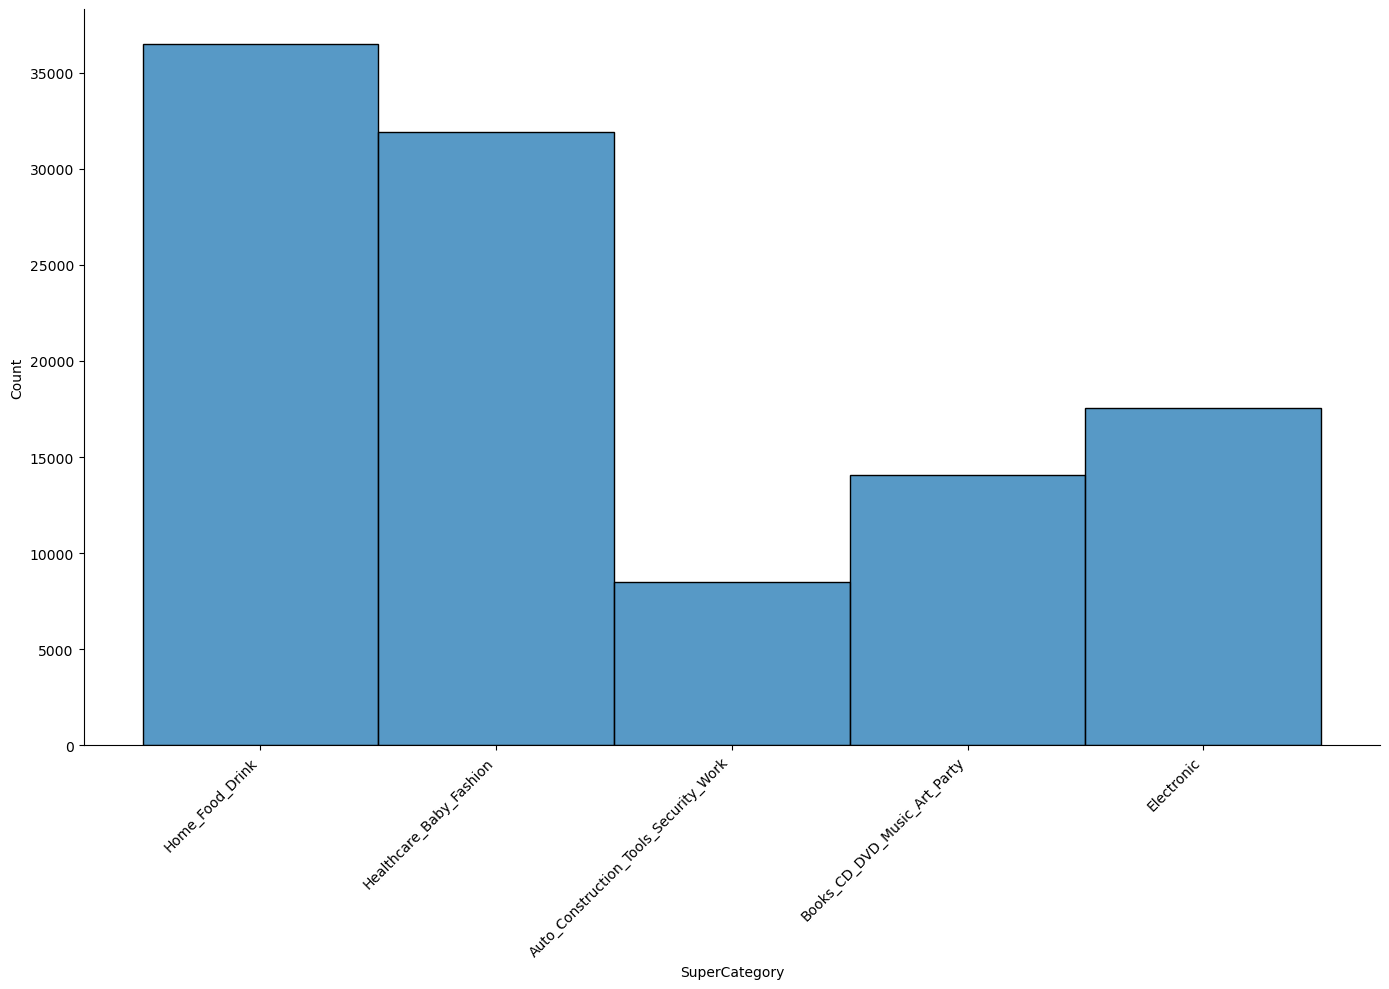

In [85]:
a=sns.displot(data=df4['SuperCategory'],height=10, aspect=14/10)
a.set_xticklabels(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [86]:
# get dummy on product_category_name_english_new

one_hot_prod_supcategory = pd.get_dummies(df4['SuperCategory'])

df6 = df4.join(one_hot_prod_supcategory)



In [87]:
df6.columns

Index(['order_id', 'customer_id', 'order_approved_at', 'customer_unique_id', 'customer_code_prefix', 'customer_city', 'customer_state', 'payment_type', 'payment_installments', 'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value', 'product_category_name', 'seller_code_prefix', 'seller_city', 'seller_state', 'product_category_name_english', 'boleto', 'credit_card', 'debit_card', 'voucher', 'ID', 'counts', 'order_total_price', 'SuperCategory', 'Auto_Construction_Tools_Security_Work', 'Books_CD_DVD_Music_Art_Party', 'Electronic', 'Healthcare_Baby_Fashion', 'Home_Food_Drink'], dtype='object')

In [88]:
## groupby combination between order_id and product_category_name_english_new
## if a client buys many product on the same product_category_name and the same order, we group them

df6['prod_order']=df6['SuperCategory']+df6['order_id']


d7={'order_id':'first', 
        'customer_id':'first', 
        'order_approved_at':'first',
        'customer_unique_id':'first', 
        'customer_code_prefix':'first', 
        'customer_city':'first',
        'customer_state':'first', 
        'payment_type':'first',
        'payment_installments':'first',
        'order_item_id':'max', 
        'product_id':'first',
        'seller_id':'first', 
        'price':'first', 
        'freight_value':'first',
        'product_category_name':'first',
        'seller_code_prefix':'first', 
        'seller_city':'first', 
        'seller_state':'first', 
        'product_category_name_english':'first',
        'boleto':'sum', 
        'credit_card':'sum', 
        'debit_card':'sum',
        'voucher':'sum',
        'ID':'first',
        'counts':'sum',
        'order_total_price':'sum', 
        'SuperCategory':'first',
   'Auto_Construction_Tools_Security_Work':'sum', 'Books_CD_DVD_Music_Art_Party':'sum', 'Electronic':'sum', 
    'Healthcare_Baby_Fashion':'sum', 'Home_Food_Drink':'sum'}


df7=(df6.groupby(['prod_order'],sort=False,as_index=False).agg(d7).reindex(columns=df6.columns))

In [89]:
df7['order_id'].value_counts()

e8c92cfd87f5f0c6d2fc5bc1df5f02b4    3
8c2b13adf3f377c8f2b06b04321b0925    3
2f8f31eb2f7b6572836d662a6625c8e4    3
a98012aa8c697f2bcff9f8c2183e0f2b    3
306b4ec62d908535f2bfa2877665e899    3
                                   ..
42769a5163a34297f4458dbccf206b36    1
d9e76f277d933820125baad40dfbb9d1    1
505ad05b659736f51f674522b701d9a5    1
cd765bd17903ea30da9a83f9c0532d16    1
2f44c5c933e193467d596a00b18fbca7    1
Name: order_id, Length: 95046, dtype: int64

In [90]:
## groupby order_id


d8={'order_id':'first', 
        'customer_id':'first', 
        'order_approved_at':'first',
        'customer_unique_id':'first', 
        'customer_code_prefix':'first', 
        'customer_city':'first',
        'customer_state':'first', 
        'payment_type':'first',
        'payment_installments':'first',
        'order_item_id':'max', 
        'product_id':'first',               # plus de sens, à supprimer
        'seller_id':'first', 
        'price':'first', 
        'freight_value':'first',
        'product_category_name':'first',  # plus de sens, à supprimer
        'seller_code_prefix':'first',     # plus de sens, à supprimer 
        'seller_city':'first',            # plus de sens, à supprimer
        'seller_state':'first',           # plus de sens, à supprimer
        'product_category_name_english':'first',   # plus de sens, à supprimer
        'boleto':'sum', 
        'credit_card':'sum', 
        'debit_card':'sum',
        'voucher':'sum',
        'ID':'first',
        'counts':'first',                  # plus de sens, à supprimer
        'order_total_price':'sum',  
        'SuperCategory':'first',         # plus de sens, à supprimer
   'Auto_Construction_Tools_Security_Work':'sum', 'Books_CD_DVD_Music_Art_Party':'sum', 'Electronic':'sum', 
    'Healthcare_Baby_Fashion':'sum', 'Home_Food_Drink':'sum'}


df8=(df7.groupby(['order_id'],sort=False,as_index=False).agg(d8).reindex(columns=df6.columns))

In [91]:
to_drop10=['product_id',
'product_category_name',
 'seller_code_prefix', 
'seller_city',  
'seller_state',
'product_category_name_english',
'counts','SuperCategory','prod_order']

df9=df8.drop(to_drop10,axis='columns')





In [92]:
df9

,order_id,customer_id,order_approved_at,customer_unique_id,customer_code_prefix,customer_city,customer_state,payment_type,payment_installments,order_item_id,seller_id,price,freight_value,boleto,credit_card,debit_card,voucher,ID,order_total_price,Auto_Construction_Tools_Security_Work,Books_CD_DVD_Music_Art_Party,Electronic,Healthcare_Baby_Fashion,Home_Food_Drink
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,credit_card,1.0,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,0,1,0,2,e481f51cbdc54678b7cc49136f2d6af7;7c396fd4830fd04220f754e42b4e5bff;87285b34884572647811a353c7ac498a1.0,38.71,0,0,0,0,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,boleto,1.0,1.0,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,1,0,0,0,53cdb2fc8bc7dce0b6741e2150273451;af07308b275d755c9edb36a90c618231;595fac2a385ac33a80bd5114aec74eb81.0,141.46,0,0,0,1,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,credit_card,3.0,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,0,1,0,0,47770eb9100c2d0c44946d9cf07ec65d;3a653a41f6f9fc3d2a113cf8398680e8;aa4383b373c6aca5d8797843e55944151.0,179.12,1,0,0,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,credit_card,1.0,1.0,66922902710d126a0e7d26b0e3805106,45.00,27.20,0,1,0,0,949d5b44dbf5de918fe9c16f97b45f8a;7c142cf63193a1473d2e66489a9ae977;d0b61bfb1de832b15ba9d266ca96e5b01.0,72.20,0,0,0,0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,credit_card,1.0,1.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,0,1,0,0,ad21c59c0840e6cb83a9ceb5573f8159;72632f0f9dd73dfee390c9b22eb56dd6;65266b2da20d04dbe00c5c2d3bb7859e1.0,28.62,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95041,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,credit_card,3.0,1.0,e24fc9fcd865784fb25705606fe3dfe7,72.00,13.08,0,1,0,0,9c5dedf39a927c1b2549525ed64a053c;6359f309b166b0196dbf7ad2ac62bb5a;ac35486adb7b02598c182c2ff2e052541.0,85.08,0,0,0,1,0
95042,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,credit_card,3.0,1.0,1f9ab4708f3056ede07124aad39a2554,174.90,20.10,0,1,0,0,63943bddc261676b46f01ca7ac2f7bd8;da62f9e57a76d978d02ab5362c509660;f1d4ce8c6dd66c47bbaa8c6781c2a9231.0,195.00,0,0,0,1,0
95043,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,credit_card,5.0,1.0,d50d79cb34e38265a8649c383dcffd48,205.99,65.02,0,1,0,0,83c1379a015df1e13d02aae0204711ab;737520a9aad80b3fbbdad19b66b37b30;b80910977a37536adeddd63663f916ad1.0,271.01,0,0,0,0,1
95044,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,credit_card,4.0,2.0,a1043bafd471dff536d0c462352beb48,179.99,40.59,0,2,0,0,11c177c8e97725db2631073c19f07b62;5097a5312c8b157bb7be58ae360ef43c;d1c427060a0f73f6b889a5c7c61f2ac41.0,661.74,0,0,2,0,0


In [93]:
df9.columns

Index(['order_id', 'customer_id', 'order_approved_at', 'customer_unique_id', 'customer_code_prefix', 'customer_city', 'customer_state', 'payment_type', 'payment_installments', 'order_item_id', 'seller_id', 'price', 'freight_value', 'boleto', 'credit_card', 'debit_card', 'voucher', 'ID', 'order_total_price', 'Auto_Construction_Tools_Security_Work', 'Books_CD_DVD_Music_Art_Party', 'Electronic', 'Healthcare_Baby_Fashion', 'Home_Food_Drink'], dtype='object')

In [152]:
#groupby customer unique_id

df_nb_order_by_customers=df9['customer_unique_id'].value_counts().to_frame()

df_nb_order_by_customers.rename(columns={'customer_unique_id':'nb_order_by_customers'},inplace=True)

df_nb_order_by_customers['customer_unique_id']=df_nb_order_by_customers.index

df_nb_order_by_customers = df_nb_order_by_customers.reset_index(drop=True)

df10=pd.merge(df9,df_nb_order_by_customers,on='customer_unique_id',how='left')

df10['last_purchase']=df10['order_approved_at']


d10={'order_id':'first',                  # plus de sens : à supp
        'customer_id':'first',           # plus de sens : à supp
        'order_approved_at':'min',
        'customer_unique_id':'first', 
        'customer_code_prefix':'first', 
        'customer_city':'first',
        'customer_state':'first', 
        'payment_type':'first',           # plus de sens : à supp
        'payment_installments':'first',
        'order_item_id':'max', 
        'seller_id':'first',              # plus de sens : à supp 
        'price':'first',                  # plus de sens : à supp
        'freight_value':'first',          # plus de sens : à supp
        'boleto':'sum', 
        'credit_card':'sum', 
        'debit_card':'sum',
        'voucher':'sum',
        'ID':'first',                     # plus de sens : à supp
        'order_total_price':'sum',       
   'Auto_Construction_Tools_Security_Work':'sum', 'Books_CD_DVD_Music_Art_Party':'sum', 'Electronic':'sum', 
    'Healthcare_Baby_Fashion':'sum', 'Home_Food_Drink':'sum',
    'nb_order_by_customers':'max','last_purchase':'max'}


df_customer_unique_id=(df10.groupby(['customer_unique_id'],sort=False,as_index=False).agg(d10).reindex(columns=df10.columns))


#7c396fd4830fd04220f754e42b4e5bff
# first purchase : 2017-09-04 11:43:25
# last purchase : 2017-10-02 11:07:15
# total price : 82.82
# nb order by custo : 2


In [153]:
to_drop_v=['order_id','customer_id','payment_type','seller_id','price','freight_value','ID']

df_customer_unique_idd = df_customer_unique_id.drop(to_drop_v,axis='columns')


In [154]:
df_customer_unique_idd.rename(columns={'order_total_price':'price_per_customer'},inplace=True)
df_customer_unique_idd.rename(columns={'order_item_id':'nb_of_items'},inplace=True)
df_customer_unique_idd.rename(columns={'order_approved_at':'first_order'},inplace=True)

In [155]:
df_customer_unique_idd.shape

(92001, 19)

### Add review score and delay 

In [156]:
df_customer_unique_id = pd.merge(df_customer_unique_idd,df_score_customer_unique,on='customer_unique_id',how='left')
df_customer_unique_id.isna().sum()

first_order                                0
customer_unique_id                         0
customer_code_prefix                       0
customer_city                              0
customer_state                             0
payment_installments                       0
nb_of_items                                0
boleto                                     0
credit_card                                0
debit_card                                 0
voucher                                    0
price_per_customer                         0
Auto_Construction_Tools_Security_Work      0
Books_CD_DVD_Music_Art_Party               0
Electronic                                 0
Healthcare_Baby_Fashion                    0
Home_Food_Drink                            0
nb_order_by_customers                      0
last_purchase                              0
order_id                                   0
review_score                               0
delivery_delay_number                    129
dtype: int

In [158]:
# imputation des Nans par la moyenne

df_customer_unique_id['delivery_delay_number'] = df_customer_unique_id['delivery_delay_number'].fillna(df_customer_unique_id['delivery_delay_number'].mean())
df_customer_unique_id.isna().sum()

first_order                              0
customer_unique_id                       0
customer_code_prefix                     0
customer_city                            0
customer_state                           0
payment_installments                     0
nb_of_items                              0
boleto                                   0
credit_card                              0
debit_card                               0
voucher                                  0
price_per_customer                       0
Auto_Construction_Tools_Security_Work    0
Books_CD_DVD_Music_Art_Party             0
Electronic                               0
Healthcare_Baby_Fashion                  0
Home_Food_Drink                          0
nb_order_by_customers                    0
last_purchase                            0
order_id                                 0
review_score                             0
delivery_delay_number                    0
dtype: int64

## Calcul du score RFM : 

In [172]:
# FirstDate


df_customer_unique_id['first_order_date']=df_customer_unique_id['first_order'].astype(str).str[:10]

df_customer_unique_id['first_order_date_2'] = pd.to_datetime(df_customer_unique_id['first_order_date'],format='%Y-%m-%d')


# LastDate


df_customer_unique_id['last_order_date']=df_customer_unique_id['last_purchase'].astype(str).str[:10]

df_customer_unique_id['last_order_date_2'] = pd.to_datetime(df_customer_unique_id['last_order_date'],format='%Y-%m-%d')

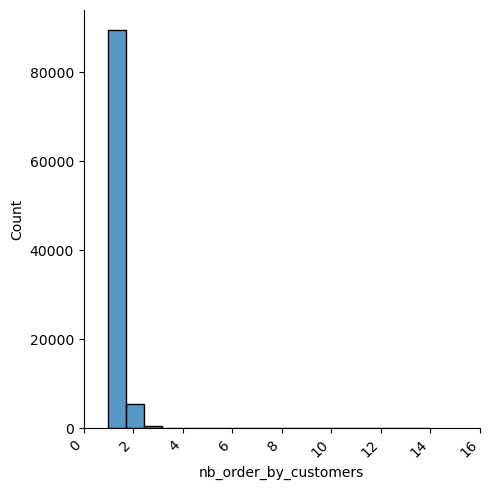

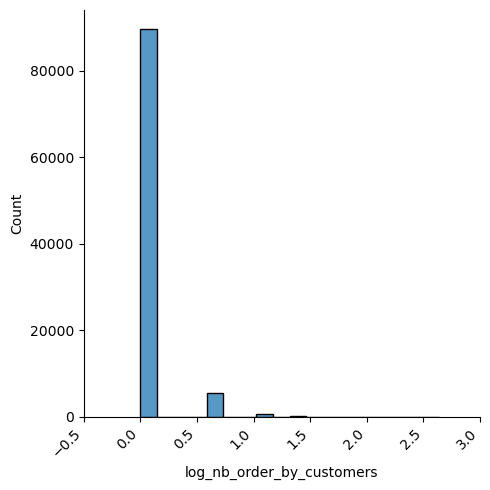

In [173]:
# RFM (récence, fréquence, montant)

## Last order known in the database :

last_order=df_customer_unique_id['last_order_date_2'].max()
first_order=df_customer_unique_id['first_order_date_2'].min()
note_LO=0

# Récence : Last Order LO

Q1_LO=df_customer_unique_id['last_order_date_2'].quantile(q=0.25)
Q2_LO=df_customer_unique_id['last_order_date_2'].quantile(q=0.5)
Q3_LO=df_customer_unique_id['last_order_date_2'].quantile(q=0.75)


nouvelle_listeLO=[]

for i in df_customer_unique_id['last_order_date_2']:
    if i>=Q3_LO :
        note_LO=4
    elif Q3_LO>i and i>=Q2_LO :
        note_LO=3
    elif Q2_LO>i and i>=Q1_LO :
        note_LO=2
    elif i<=Q1_LO :
        note_LO=1
               
    nouvelle_listeLO.append(note_LO)
    
df_customer_unique_id['Récence']=nouvelle_listeLO


# Fréquence : F : number of orders passed between the first order known in the database (2018-08-29) and the order known in the database (2018-08-29)


#df_customer_unique_id['Laps_Time']=(last_order-first_order)

#df_customer_unique_id["Laps_Time"] = df_customer_unique_id.Laps_Time.dt.days

#df_customer_unique_id['Fréquence_Value']=10000*df_customer_unique_id['nb_order_by_customers']/df_customer_unique_id["Laps_Time"]

a=sns.displot(data=df_customer_unique_id['nb_order_by_customers'])
a.set_xticklabels(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_customer_unique_id[df_customer_unique_id['nb_order_by_customers']>1].describe()

## try with the log :

df_customer_unique_id['log_nb_order_by_customers']=np.log(df_customer_unique_id['nb_order_by_customers'])

a=sns.displot(data=df_customer_unique_id['log_nb_order_by_customers'])
a.set_xticklabels(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_customer_unique_id['log_nb_order_by_customers'].describe()



## For the Frequency, we'll note 1 if customer passed 1 order, 2 if he passed more than 1 order :

nouvelle_listeF=[]

for i in df_customer_unique_id['nb_order_by_customers']:
    if i==1 :
        note_F=1
    elif i>1 :
        note_F=2
               
    nouvelle_listeF.append(note_F)
    
df_customer_unique_id['Fréquence']=nouvelle_listeF


# Monetary :

df_customer_unique_id['price_per_customer'].describe()

Q1_M=df_customer_unique_id['price_per_customer'].quantile(q=0.25)
Q2_M=df_customer_unique_id['price_per_customer'].quantile(q=0.5)
Q3_M=df_customer_unique_id['price_per_customer'].quantile(q=0.75)


nouvelle_listeM=[]

for i in df_customer_unique_id['price_per_customer']:
    if i>=Q3_M :
        note_M=4
    elif Q3_M>i and i>=Q2_M :
        note_M=3
    elif Q2_M>i and i>=Q1_M :
        note_M=2
    elif i<=Q1_M :
        note_M=1
               
    nouvelle_listeM.append(note_M)
    
df_customer_unique_id['Monetary']=nouvelle_listeM




to_drop20=['first_order_date','last_order_date','log_nb_order_by_customers'] 

In [174]:
df_customer_unique_id.head(2)

,first_order,customer_unique_id,customer_code_prefix,customer_city,customer_state,payment_installments,nb_of_items,boleto,credit_card,debit_card,voucher,price_per_customer,Auto_Construction_Tools_Security_Work,Books_CD_DVD_Music_Art_Party,Electronic,Healthcare_Baby_Fashion,Home_Food_Drink,nb_order_by_customers,last_purchase,order_id,review_score,delivery_delay_number,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,LAT,LNG,GEO,first_order_date,first_order_date_2,last_order_date,last_order_date_2,Récence,log_nb_order_by_customers,Fréquence,Monetary
0,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,69923a4e07ce446644394df37a710286,5,1.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-09-04,2017-10-02,2017-10-02,2,0.693147,2,2
1,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,4,8.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-09-04,2017-10-02,2017-10-02,2,0.693147,2,2


In [175]:
# creation of a new columns to have numbers for recency.

df_customer_unique_id['days_from_last_command']=last_order-df_customer_unique_id['last_order_date_2']

In [176]:
df_customer_unique_id.head(2)

,first_order,customer_unique_id,customer_code_prefix,customer_city,customer_state,payment_installments,nb_of_items,boleto,credit_card,debit_card,voucher,price_per_customer,Auto_Construction_Tools_Security_Work,Books_CD_DVD_Music_Art_Party,Electronic,Healthcare_Baby_Fashion,Home_Food_Drink,nb_order_by_customers,last_purchase,order_id,review_score,delivery_delay_number,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,LAT,LNG,GEO,first_order_date,first_order_date_2,last_order_date,last_order_date_2,Récence,log_nb_order_by_customers,Fréquence,Monetary,days_from_last_command
0,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,69923a4e07ce446644394df37a710286,5,1.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-09-04,2017-10-02,2017-10-02,2,0.693147,2,2,331 days
1,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,4,8.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-09-04,2017-10-02,2017-10-02,2,0.693147,2,2,331 days


In [177]:
df_customer_unique_id=df_customer_unique_id.drop(to_drop20,axis='columns')


In [178]:
df_customer_unique_id['RFM_Cell']=df_customer_unique_id['Récence'].astype(str)+','+df_customer_unique_id['Fréquence'].astype(str)+','+df_customer_unique_id['Monetary'].astype(str)

df_customer_unique_id['RFM_Score']=(df_customer_unique_id['Récence']+df_customer_unique_id['Fréquence']+df_customer_unique_id['Monetary'])/3

df_customer_unique_id['customer_state'].value_counts()

SP    40222
RJ    12263
MG    11270
RS     5312
PR     4879
SC     3500
BA     3237
DF     2066
ES     1990
GO     1935
PE     1584
CE     1267
PA      936
MT      877
MA      717
MS      701
PB      511
RN      471
PI      470
AL      399
SE      333
TO      270
RO      238
AM      146
AC       78
AP       67
RR       39
Name: customer_state, dtype: int64

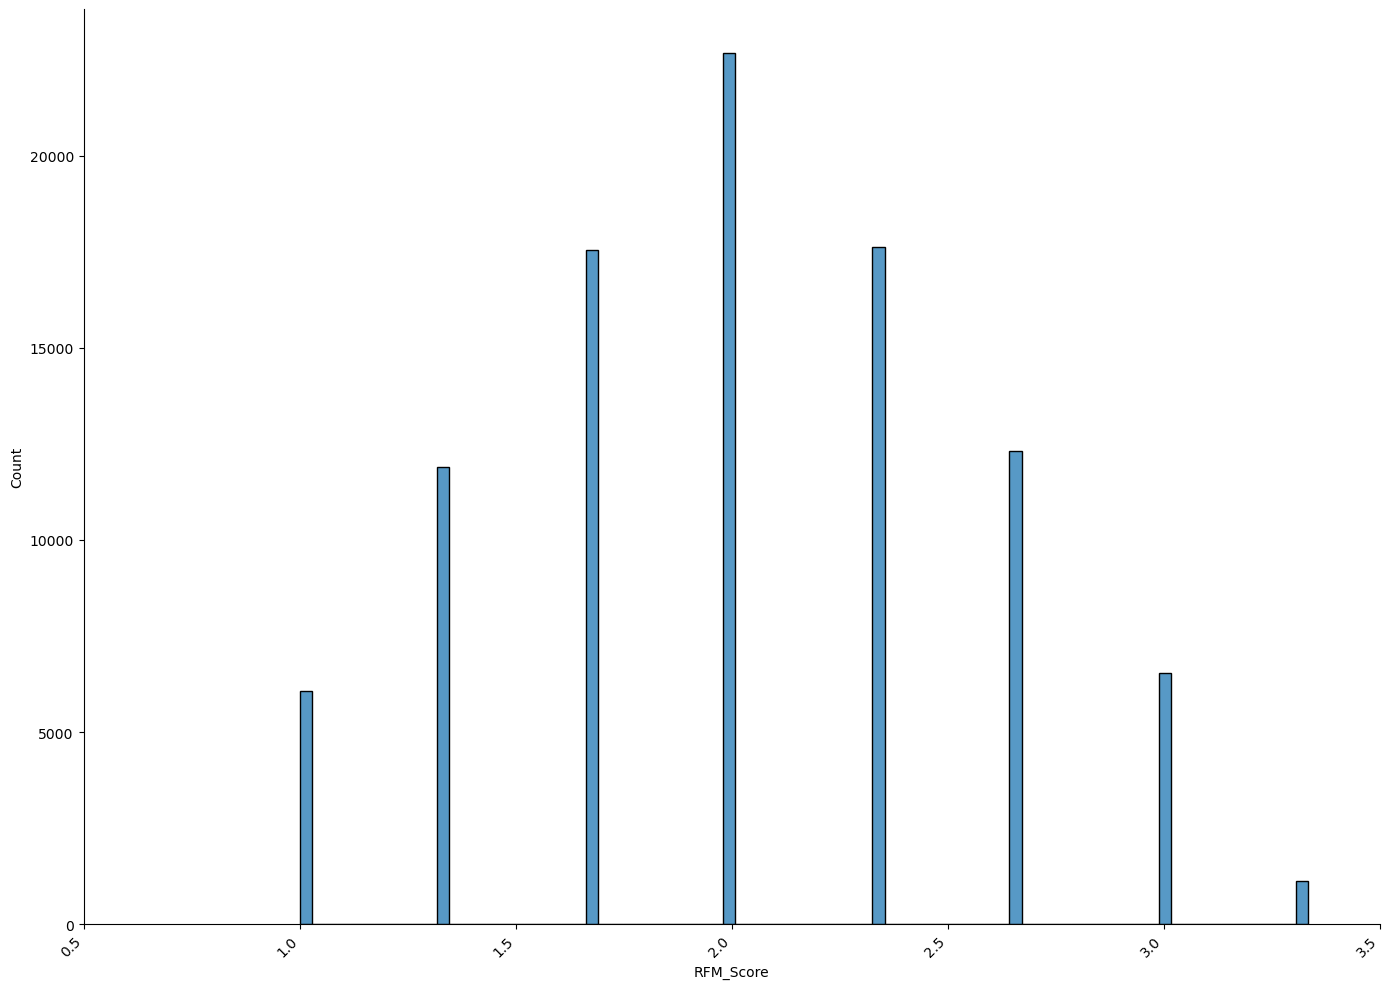

In [179]:
a=sns.displot(data=df_customer_unique_id['RFM_Score'],height=10, aspect=14/10)
a.set_xticklabels(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [182]:
# Group by region : SE, NE, SW, NW


df_geolocation['geolocation_lat'].describe()

df_geolocation

df_geolocation.rename(columns={'zip_code_prefix':'customer_code_prefix'},inplace=True)


df_customer_unique_id=df_customer_unique_id.merge(df_geolocation,on='customer_code_prefix',how='left')


df_customer_unique_id

nouvelle_liste_LAT=[]
nouvelle_liste_LNG=[]

lng_mean=-46.631931
lat_mean=-22.416053

for i in df_customer_unique_id['geolocation_lat']:
    if i>lat_mean:
        lat='N'
    elif i<lat_mean:
        lat='S'
    
    nouvelle_liste_LAT.append(lat)

df_customer_unique_id['LAT']=nouvelle_liste_LAT

for i in df_customer_unique_id['geolocation_lng']:
    if i>lng_mean:
        lng='E'
    elif i<lng_mean:
        lng='W'
    
    nouvelle_liste_LNG.append(lng)

df_customer_unique_id['LNG']=nouvelle_liste_LNG

df_customer_unique_id['GEO']=df_customer_unique_id['LAT']+df_customer_unique_id['LNG']

In [382]:
one_hot_geo = pd.get_dummies(df_customer_unique_id['GEO'])

df_customer_unique_id2 = df_customer_unique_id.join(one_hot_geo)

df_customer_unique_id2.shape

(95778, 49)

In [184]:
df_customer_unique_id.columns

Index(['first_order', 'customer_unique_id', 'customer_code_prefix', 'customer_city', 'customer_state', 'payment_installments', 'nb_of_items', 'boleto', 'credit_card', 'debit_card', 'voucher', 'price_per_customer', 'Auto_Construction_Tools_Security_Work', 'Books_CD_DVD_Music_Art_Party', 'Electronic', 'Healthcare_Baby_Fashion', 'Home_Food_Drink', 'nb_order_by_customers', 'last_purchase', 'order_id', 'review_score', 'delivery_delay_number', 'geolocation_lat_x', 'geolocation_lng_x', 'geolocation_city_x', 'geolocation_state_x', 'LAT', 'LNG', 'GEO', 'first_order_date_2', 'last_order_date_2', 'Récence', 'Fréquence', 'Monetary', 'days_from_last_command', 'RFM_Cell', 'RFM_Score', 'geolocation_lat_y', 'geolocation_lng_y', 'geolocation_city_y', 'geolocation_state_y', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'], dtype='object')

In [381]:
df_customer_unique_id.shape

(95778, 45)

In [185]:
df_customer_unique_id2.columns

Index(['first_order', 'customer_unique_id', 'customer_code_prefix', 'customer_city', 'customer_state', 'payment_installments', 'nb_of_items', 'boleto', 'credit_card', 'debit_card', 'voucher', 'price_per_customer', 'Auto_Construction_Tools_Security_Work', 'Books_CD_DVD_Music_Art_Party', 'Electronic', 'Healthcare_Baby_Fashion', 'Home_Food_Drink', 'nb_order_by_customers', 'last_purchase', 'order_id', 'review_score', 'delivery_delay_number', 'geolocation_lat_x', 'geolocation_lng_x', 'geolocation_city_x', 'geolocation_state_x', 'LAT', 'LNG', 'GEO', 'first_order_date_2', 'last_order_date_2', 'Récence', 'Fréquence', 'Monetary', 'days_from_last_command', 'RFM_Cell', 'RFM_Score', 'geolocation_lat_y', 'geolocation_lng_y', 'geolocation_city_y', 'geolocation_state_y', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state', 'NE', 'NW', 'SE', 'SW'], dtype='object')

In [186]:
df_customer_unique_id2.describe()

,customer_code_prefix,payment_installments,nb_of_items,boleto,credit_card,debit_card,voucher,price_per_customer,Auto_Construction_Tools_Security_Work,Books_CD_DVD_Music_Art_Party,Electronic,Healthcare_Baby_Fashion,Home_Food_Drink,nb_order_by_customers,review_score,delivery_delay_number,geolocation_lat_x,geolocation_lng_x,Récence,Fréquence,Monetary,days_from_last_command,RFM_Score,geolocation_lat_y,geolocation_lng_y,geolocation_lat,geolocation_lng,NE,NW,SE,SW
count,95778.00000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95519.000000,95519.000000,95778.000000,95778.000000,95778.000000,95778,95778.000000,95519.000000,95519.000000,95519.000000,95519.000000,95778.000000,95778.000000,95778.000000,95778.000000
mean,35176.73282,2.921172,1.154764,0.251759,0.955543,0.017969,0.070893,193.521403,0.094750,0.156278,0.196757,0.365428,0.427541,1.080102,4.140899,12.498887,-21.202701,-46.185514,2.505826,1.065286,2.500261,235 days 22:42:47.788009148,2.023791,-21.202701,-46.185514,-21.202701,-46.185514,0.229844,0.148186,0.270563,0.351406
std,29829.41253,2.713240,0.565134,0.616789,0.841729,0.155707,0.629492,348.846906,0.379931,0.420717,0.530132,0.635101,0.785262,0.376540,1.297727,9.539851,5.598216,4.053107,1.119844,0.247032,1.118021,152 days 07:55:28.945559620,0.552153,5.598216,4.053107,5.598216,4.053107,0.420735,0.355287,0.444253,0.477412
min,1003.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.590000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-33.689948,-72.668881,1.000000,1.000000,1.000000,0 days 00:00:00,1.000000,-33.689948,-72.668881,-33.689948,-72.668881,0.000000,0.000000,0.000000,0.000000
25%,11347.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,64.860000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,7.000000,-23.589851,-48.109940,2.000000,1.000000,2.000000,113 days 00:00:00,1.666667,-23.589851,-48.109940,-23.589851,-48.109940,0.000000,0.000000,0.000000,0.000000
50%,24431.00000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,114.440000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,10.000000,-22.924970,-46.631239,3.000000,1.000000,3.000000,217 days 00:00:00,2.000000,-22.924970,-46.631239,-22.924970,-46.631239,0.000000,0.000000,0.000000,0.000000
75%,59022.00000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,202.145000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.000000,16.000000,-20.140216,-43.622642,4.000000,1.000000,3.750000,344 days 00:00:00,2.333333,-20.140216,-43.622642,-20.140216,-43.622642,0.000000,0.000000,1.000000,1.000000
max,99980.00000,24.000000,21.000000,20.000000,24.000000,7.000000,75.000000,23759.400000,20.000000,12.000000,24.000000,21.000000,18.000000,14.000000,5.000000,210.000000,42.184003,-8.723762,4.000000,2.000000,4.000000,694 days 00:00:00,3.333333,42.184003,-8.723762,42.184003,-8.723762,1.000000,1.000000,1.000000,1.000000


In [384]:
df_customer_unique_id2['R,F,M']=df_customer_unique_id2['Récence'].astype(str)+','+df_customer_unique_id2['Fréquence'].astype(str)+','+df_customer_unique_id2['Monetary'].astype(str)

In [385]:
df_customer_unique_id2['R,F,M'].value_counts()

1,1,1    6056
1,1,2    5972
2,1,2    5962
3,1,1    5960
4,1,1    5925
2,1,1    5888
4,1,3    5823
4,1,2    5678
3,1,2    5635
3,1,3    5546
2,1,3    5492
1,1,3    5430
4,1,4    5103
1,1,4    5052
2,1,4    5021
3,1,4    4982
4,2,4    1114
3,2,4    1048
2,2,4     891
1,2,4     734
3,2,3     463
2,2,3     425
4,2,3     397
1,2,3     390
1,2,2     181
3,2,2     177
2,2,2     161
4,2,2     159
1,2,1      38
4,2,1      32
3,2,1      27
2,2,1      16
Name: R,F,M, dtype: int64

In [386]:
Champions=['4,2,4','3,2,4','3,2,3','4,2,3']

In [387]:
Fideles=['3,2,2','4,2,2','4,2,1','3,2,1']

In [388]:
Recent=['4,1,3','4,1,1','3,1,1','4,1,2',
       '3,1,2']

In [389]:
Prometteurs=['3,1,3','4,1,4','3,1,4']

In [390]:
A_risque=['2,1,2','2,1,1','2,1,3',
         '2,1,4','2,2,4','2,2,3',
         '2,2,2','2,2,1']

In [391]:
Lost=['1,1,2','1,1,1','1,1,3','1,1,4',
     '1,2,4','1,2,3','1,2,2','1,2,1'
     ]

In [392]:
Segmentation=[]

for z in df_customer_unique_id2['R,F,M']:
    if z in Champions:
        seg="Champions"
    if z in Fideles:
        seg="Fideles"
    if z in Recent:
        seg="Recent"
    if z in Prometteurs:
        seg="Prometteurs"
    if z in A_risque:
        seg="A_risque"
    if z in Lost:
        seg="Lost"  
        
    Segmentation.append(seg) 

    

In [394]:
df_customer_unique_id2['Segmentation']=Segmentation
df_customer_unique_id2.shape

(95778, 51)

In [395]:
Segmentation_class=[]

for zz in df_customer_unique_id2['Segmentation']:
    if zz=='Champions':
        seg=0
    if zz=='Fideles':
        seg=1
    if zz=='Recent':
        seg=2
    if zz=='Prometteurs':
        seg=3
    if zz=='A_risque':
        seg=4
    if zz=='Lost':
        seg=5 
        
    Segmentation_class.append(seg) 

df_customer_unique_id2['Segmentation_class']=Segmentation_class

In [396]:
df_customer_unique_id2.shape

(95778, 52)

In [397]:
df_customer_unique_id2['days_from_last_command_nb']=df_customer_unique_id2['days_from_last_command']/pd.to_timedelta(1, unit='D')

In [398]:
list_of_interest=['Récence','Fréquence','Monetary','nb_order_by_customers','payment_installments','days_from_last_command_nb','price_per_customer']


In [399]:
df_customer_unique_id2[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000,95778.000000
mean,2.505826,1.065286,2.500261,1.080102,2.921172,235.946386,193.521403
std,1.119844,0.247032,1.118021,0.376540,2.713240,152.330196,348.846906
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.590000
25%,2.000000,1.000000,2.000000,1.000000,1.000000,113.000000,64.860000
50%,3.000000,1.000000,3.000000,1.000000,2.000000,217.000000,114.440000
75%,4.000000,1.000000,3.750000,1.000000,4.000000,344.000000,202.145000
max,4.000000,2.000000,4.000000,14.000000,24.000000,694.000000,23759.400000


In [400]:
liste_seg=['Champions','Fideles','Recent','Prometteurs','A_risque','Lost']

df_Champions=df_customer_unique_id2[df_customer_unique_id2['Segmentation']=='Champions']
df_Fideles=df_customer_unique_id2[df_customer_unique_id2['Segmentation']=='Fideles']
df_Recent=df_customer_unique_id2[df_customer_unique_id2['Segmentation']=='Recent']
df_Prometteurs=df_customer_unique_id2[df_customer_unique_id2['Segmentation']=='Prometteurs']
df_A_risque=df_customer_unique_id2[df_customer_unique_id2['Segmentation']=='A_risque']
df_Lost=df_customer_unique_id2[df_customer_unique_id2['Segmentation']=='Lost']

In [401]:
df_Champions[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,3022.000000,3022.0,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000
mean,3.500000,2.0,3.715420,2.352085,3.325281,112.420913,473.274537
std,0.500083,0.0,0.451289,1.180132,2.992059,63.835083,826.498796
min,3.000000,2.0,3.000000,2.000000,1.000000,0.000000,114.760000
25%,3.000000,2.0,3.000000,2.000000,1.000000,55.000000,192.630000
50%,3.500000,2.0,4.000000,2.000000,2.000000,113.500000,295.315000
75%,4.000000,2.0,4.000000,2.000000,5.000000,173.000000,489.502500
max,4.000000,2.0,4.000000,14.000000,18.000000,217.000000,16295.580000


In [402]:
df_Fideles[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,395.000000,395.0,395.000000,395.000000,395.000000,395.000000,395.000000
mean,3.483544,2.0,1.850633,2.007595,1.691139,114.301266,85.738304
std,0.500363,0.0,0.356902,0.086927,1.331309,62.622452,19.807677
min,3.000000,2.0,1.000000,2.000000,1.000000,0.000000,35.940000
25%,3.000000,2.0,2.000000,2.000000,1.000000,60.000000,70.790000
50%,3.000000,2.0,2.000000,2.000000,1.000000,117.000000,88.180000
75%,4.000000,2.0,2.000000,2.000000,2.000000,165.500000,102.310000
max,4.000000,2.0,2.000000,3.000000,10.000000,217.000000,113.950000


In [403]:
df_Recent[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,29021.000000,29021.0,29021.000000,29021.0,29021.000000,29021.000000,29021.000000
mean,3.600462,1.0,1.791117,1.0,2.174942,99.876572,82.796034
std,0.489812,0.0,0.752706,0.0,1.974011,62.449452,42.872881
min,3.000000,1.0,1.000000,1.0,0.000000,0.000000,9.590000
25%,3.000000,1.0,1.000000,1.0,1.000000,42.000000,48.340000
50%,4.000000,1.0,2.000000,1.0,1.000000,98.000000,73.710000
75%,4.000000,1.0,2.000000,1.0,3.000000,154.000000,107.200000
max,4.000000,1.0,3.000000,1.0,18.000000,217.000000,202.070000


In [404]:
df_Prometteurs[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,15631.000000,15631.0,15631.000000,15631.0,15631.000000,15631.000000,15631.000000
mean,3.326467,1.0,3.645192,1.0,3.888299,129.401062,363.348182
std,0.468935,0.0,0.478470,0.0,3.129892,58.573594,478.244214
min,3.000000,1.0,3.000000,1.0,1.000000,0.000000,114.440000
25%,3.000000,1.0,3.000000,1.0,1.000000,87.000000,168.990000
50%,3.000000,1.0,4.000000,1.0,3.000000,138.000000,237.070000
75%,4.000000,1.0,4.000000,1.0,6.000000,177.000000,378.220000
max,4.000000,1.0,4.000000,1.0,24.000000,217.000000,23125.200000


In [405]:
df_A_risque[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,23856.0,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000
mean,2.0,1.062584,2.496185,1.069584,2.930332,275.546571,191.434341
std,0.0,0.242218,1.113844,0.285798,2.783264,34.947616,331.597005
min,2.0,1.000000,1.000000,1.000000,1.000000,218.000000,11.630000
25%,2.0,1.000000,2.000000,1.000000,1.000000,247.000000,65.010000
50%,2.0,1.000000,2.000000,1.000000,2.000000,275.000000,113.155000
75%,2.0,1.000000,3.000000,1.000000,4.000000,302.000000,200.537500
max,2.0,2.000000,4.000000,5.000000,24.000000,344.000000,12616.100000


In [406]:
df_Lost[list_of_interest].describe()

,Récence,Fréquence,Monetary,nb_order_by_customers,payment_installments,days_from_last_command_nb,price_per_customer
count,23853.0,23853.000000,23853.000000,23853.000000,23853.000000,23853.000000,23853.000000
mean,1.0,1.056303,2.473651,1.064059,3.155326,449.375886,185.377683
std,0.0,0.230511,1.116001,0.281949,2.845758,71.511884,309.926678
min,1.0,1.000000,1.000000,1.000000,1.000000,345.000000,10.070000
25%,1.0,1.000000,1.000000,1.000000,1.000000,390.000000,64.110000
50%,1.0,1.000000,2.000000,1.000000,2.000000,442.000000,111.030000
75%,1.0,1.000000,3.000000,1.000000,4.000000,500.000000,196.710000
max,1.0,2.000000,4.000000,6.000000,20.000000,694.000000,23759.400000


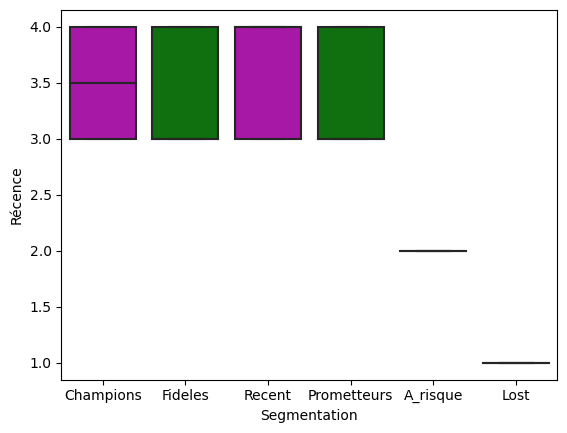

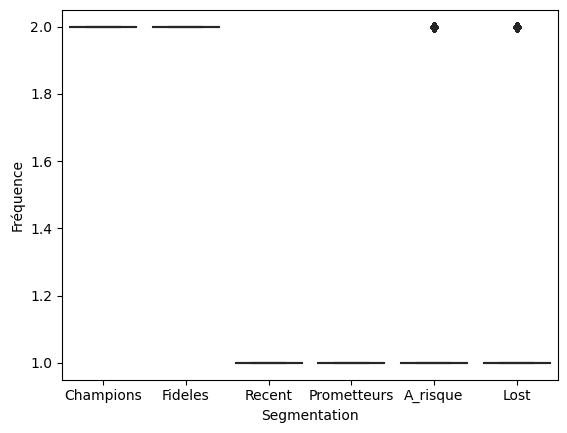

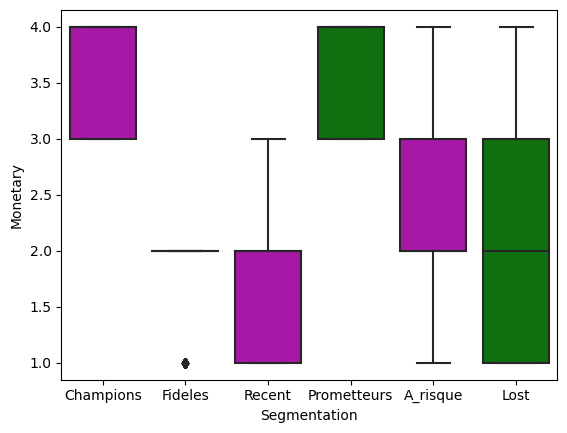

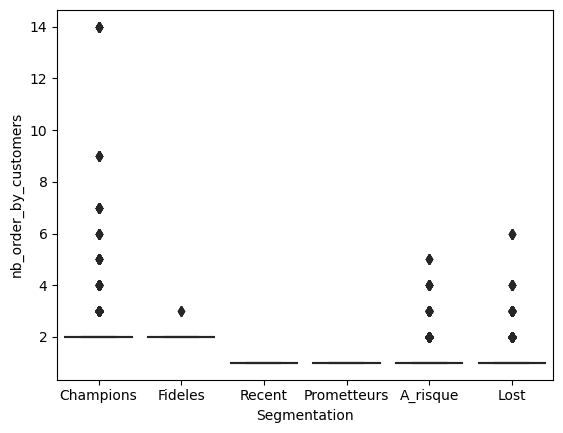

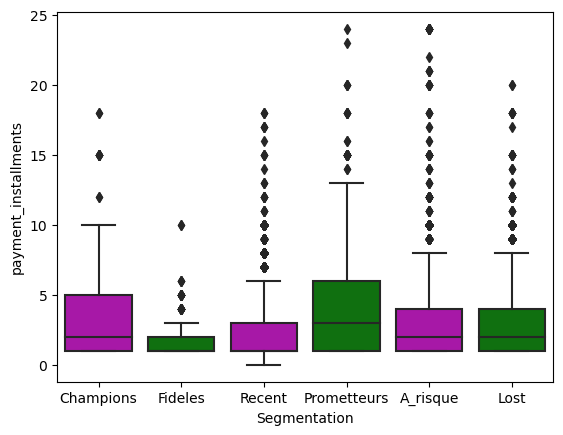

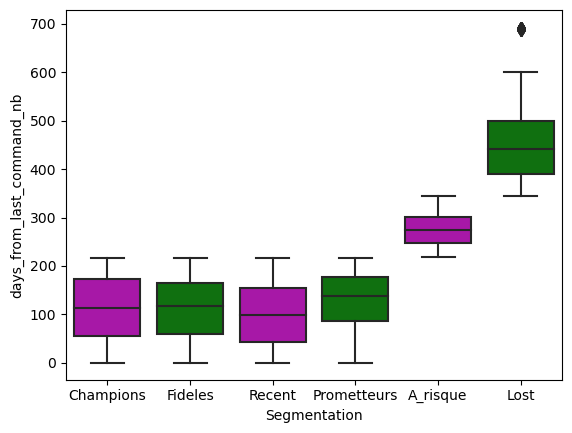

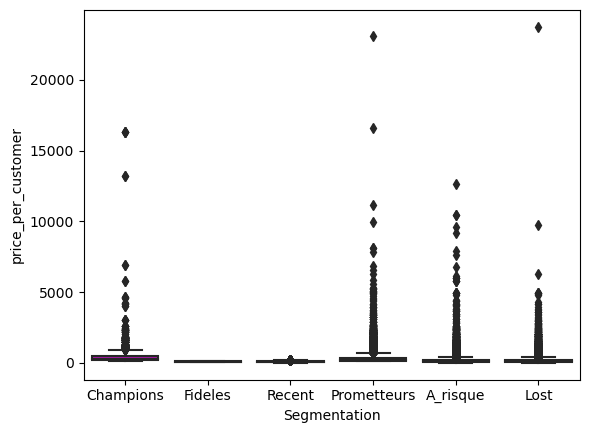

In [407]:
#Faire des boxplots de l'évolution des différentes variables de liste ACP 3 en fonction de la category de client


yk=list_of_interest

for i in yk:
    sns.boxplot(x='Segmentation',y=i,palette=["m", "g"],order=liste_seg,
            data=df_customer_unique_id2)

    plt.show()

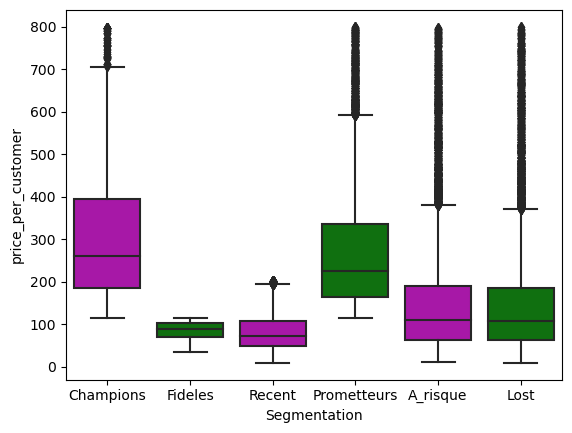

In [408]:
sns.boxplot(x='Segmentation',y='price_per_customer',palette=["m", "g"],order=liste_seg,
            data=df_customer_unique_id2[df_customer_unique_id2['price_per_customer']<800])
plt.show()

In [409]:
df_customer_unique_id2

,first_order,customer_unique_id,customer_code_prefix,customer_city,customer_state,payment_installments,nb_of_items,boleto,credit_card,debit_card,voucher,price_per_customer,Auto_Construction_Tools_Security_Work,Books_CD_DVD_Music_Art_Party,Electronic,Healthcare_Baby_Fashion,Home_Food_Drink,nb_order_by_customers,last_purchase,order_id,review_score,delivery_delay_number,geolocation_lat_x,geolocation_lng_x,geolocation_city_x,geolocation_state_x,LAT,LNG,GEO,first_order_date_2,last_order_date_2,Récence,Fréquence,Monetary,days_from_last_command,RFM_Cell,RFM_Score,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,geolocation_state_y,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,NE,NW,SE,SW,"R,F,M",Segmentation,Segmentation_class,days_from_last_command_nb
0,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,69923a4e07ce446644394df37a710286,5,1.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-10-02,2,2,2,331 days,"2,2,2",2.000000,-23.576983,-46.587161,sao paulo,SP,-23.576983,-46.587161,sao paulo,SP,0,0,1,0,"2,2,2",A_risque,4,331.0
1,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,4,8.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-10-02,2,2,2,331 days,"2,2,2",2.000000,-23.576983,-46.587161,sao paulo,SP,-23.576983,-46.587161,sao paulo,SP,0,0,1,0,"2,2,2",A_risque,4,331.0
2,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,1.0,1,0,0,0,141.46,0,0,0,1,0,1,2018-07-26 03:24:27,53cdb2fc8bc7dce0b6741e2150273451,4,14.0,-12.177924,-44.660711,barreiras,BA,N,E,NE,2018-07-26,2018-07-26,4,1,3,34 days,"4,1,3",2.666667,-12.177924,-44.660711,barreiras,BA,-12.177924,-44.660711,barreiras,BA,1,0,0,0,"4,1,3",Recent,2,34.0
3,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,3.0,1.0,0,1,0,0,179.12,1,0,0,0,0,1,2018-08-08 08:55:23,47770eb9100c2d0c44946d9cf07ec65d,5,9.0,-16.745150,-48.514783,vianopolis,GO,N,W,NW,2018-08-08,2018-08-08,4,1,3,21 days,"4,1,3",2.666667,-16.745150,-48.514783,vianopolis,GO,-16.745150,-48.514783,vianopolis,GO,0,1,0,0,"4,1,3",Recent,2,21.0
4,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,1.0,0,1,0,0,72.20,0,0,0,0,1,1,2017-11-18 19:45:59,949d5b44dbf5de918fe9c16f97b45f8a,5,14.0,-5.774190,-35.271143,sao goncalo do amarante,RN,N,E,NE,2017-11-18,2017-11-18,2,1,2,284 days,"2,1,2",1.666667,-5.774190,-35.271143,sao goncalo do amarante,RN,-5.774190,-35.271143,sao goncalo do amarante,RN,1,0,0,0,"2,1,2",A_risque,4,284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95773,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,3.0,1.0,0,1,0,0,85.08,0,0,0,1,0,1,2017-03-09 09:54:05,9c5dedf39a927c1b2549525ed64a053c,5,8.0,-23.178000,-45.883818,são josé dos campos,SP,S,E,SE,2017-03-09,2017-03-09,1,1,2,538 days,"1,1,2",1.333333,-23.178000,-45.883818,são josé dos campos,SP,-23.178000,-45.883818,são josé dos campos,SP,0,0,1,0,"1,1,2",Lost,5,538.0
95774,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,3.0,1.0,0,1,0,0,195.00,0,0,0,1,0,1,2018-02-06 13:10:37,63943bddc261676b46f01ca7ac2f7bd8,4,22.0,-24.001500,-46.449864,praia grande,SP,S,E,SE,2018-02-06,2018-02-06,3,1,3,204 days,"3,1,3",2.333333,-24.001500,-46.449864,praia grande,SP,-24.001500,-46.449864,praia grande,SP,0,0,1,0,"3,1,3",Prometteurs,3,204.0
95775,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,5.0,1.0,0,1,0,0,271.01,0,0,0,0,1,1,2017-08-27 15:04:16,83c1379a015df1e13d02aae0204711ab,5,25.0,-17.898358,-39.373630,nova vicosa,BA,N,E,NE,2017-08-27,2017-08-27,1,1,4,367 days,"1,1,4",2.000000,-17.898358,-39.373630,nova vicosa,BA,-17.898358,-39.37

In [410]:
## Projection des individus sur les axes Prix / Récence :

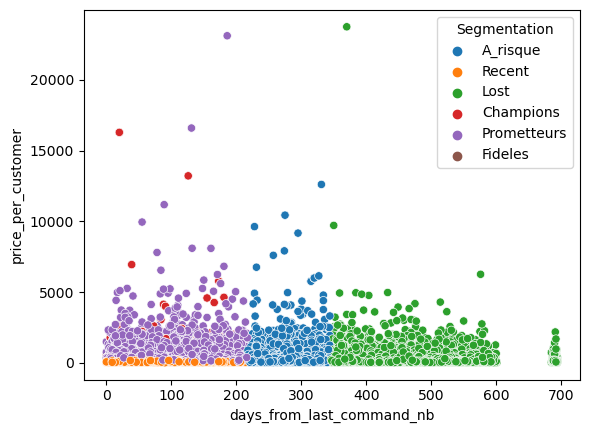

In [411]:
sns.scatterplot(data=df_customer_unique_id2, x="days_from_last_command_nb", y="price_per_customer",hue="Segmentation")
plt.show()

In [412]:
## segmentation vs review score : 

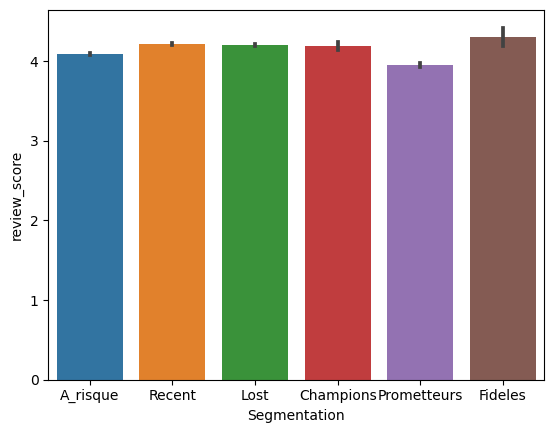

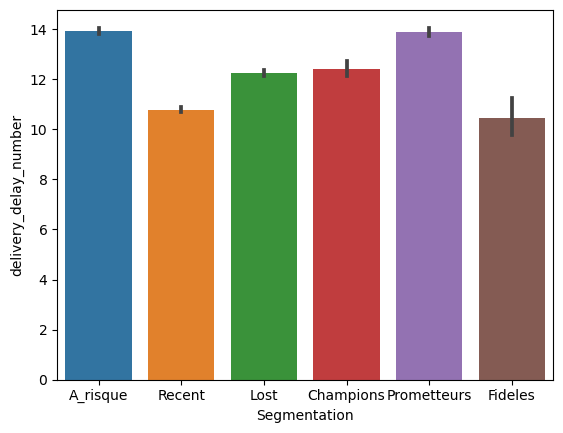

In [413]:
d_S_R = {'review_score':'mean'}

seg_rscore = (df_customer_unique_id2.groupby(['Segmentation'],sort=False,as_index=False).agg(d_S_R).reindex(columns=df_customer_unique_id2.columns))

sns.barplot(data=df_customer_unique_id2, y="review_score", x="Segmentation")
plt.show()


d_S_D = {'delivery_delay_number':'mean'}

seg_delivdelay = (df_customer_unique_id2.groupby(['Segmentation'],sort=False,as_index=False).agg(d_S_D).reindex(columns=df_customer_unique_id2.columns))

sns.barplot(data=df_customer_unique_id2, y="delivery_delay_number", x="Segmentation")
plt.show()


In [414]:
## Projection des individus par catégorie :

In [451]:
df_pro = df4[['customer_unique_id','product_category_name_english']]

df_pro = df_pro.drop_duplicates()

df_pro

df_customer_unique_id2 = df_customer_unique_id2.drop_duplicates()
df_customer_unique_id2

,first_order,customer_unique_id,customer_code_prefix,customer_city,customer_state,payment_installments,nb_of_items,boleto,credit_card,debit_card,voucher,price_per_customer,Auto_Construction_Tools_Security_Work,Books_CD_DVD_Music_Art_Party,Electronic,Healthcare_Baby_Fashion,Home_Food_Drink,nb_order_by_customers,last_purchase,order_id,review_score,delivery_delay_number,geolocation_lat_x,geolocation_lng_x,geolocation_city_x,geolocation_state_x,LAT,LNG,GEO,first_order_date_2,last_order_date_2,Récence,Fréquence,Monetary,days_from_last_command,RFM_Cell,RFM_Score,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,geolocation_state_y,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,NE,NW,SE,SW,"R,F,M",Segmentation,Segmentation_class,days_from_last_command_nb
0,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,69923a4e07ce446644394df37a710286,5,1.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-10-02,2,2,2,331 days,"2,2,2",2.000000,-23.576983,-46.587161,sao paulo,SP,-23.576983,-46.587161,sao paulo,SP,0,0,1,0,"2,2,2",A_risque,4,331.0
1,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,1.0,0,2,0,2,82.82,0,0,0,1,1,2,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,4,8.0,-23.576983,-46.587161,sao paulo,SP,S,E,SE,2017-09-04,2017-10-02,2,2,2,331 days,"2,2,2",2.000000,-23.576983,-46.587161,sao paulo,SP,-23.576983,-46.587161,sao paulo,SP,0,0,1,0,"2,2,2",A_risque,4,331.0
2,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,1.0,1,0,0,0,141.46,0,0,0,1,0,1,2018-07-26 03:24:27,53cdb2fc8bc7dce0b6741e2150273451,4,14.0,-12.177924,-44.660711,barreiras,BA,N,E,NE,2018-07-26,2018-07-26,4,1,3,34 days,"4,1,3",2.666667,-12.177924,-44.660711,barreiras,BA,-12.177924,-44.660711,barreiras,BA,1,0,0,0,"4,1,3",Recent,2,34.0
3,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,3.0,1.0,0,1,0,0,179.12,1,0,0,0,0,1,2018-08-08 08:55:23,47770eb9100c2d0c44946d9cf07ec65d,5,9.0,-16.745150,-48.514783,vianopolis,GO,N,W,NW,2018-08-08,2018-08-08,4,1,3,21 days,"4,1,3",2.666667,-16.745150,-48.514783,vianopolis,GO,-16.745150,-48.514783,vianopolis,GO,0,1,0,0,"4,1,3",Recent,2,21.0
4,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,1.0,0,1,0,0,72.20,0,0,0,0,1,1,2017-11-18 19:45:59,949d5b44dbf5de918fe9c16f97b45f8a,5,14.0,-5.774190,-35.271143,sao goncalo do amarante,RN,N,E,NE,2017-11-18,2017-11-18,2,1,2,284 days,"2,1,2",1.666667,-5.774190,-35.271143,sao goncalo do amarante,RN,-5.774190,-35.271143,sao goncalo do amarante,RN,1,0,0,0,"2,1,2",A_risque,4,284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95773,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,3.0,1.0,0,1,0,0,85.08,0,0,0,1,0,1,2017-03-09 09:54:05,9c5dedf39a927c1b2549525ed64a053c,5,8.0,-23.178000,-45.883818,são josé dos campos,SP,S,E,SE,2017-03-09,2017-03-09,1,1,2,538 days,"1,1,2",1.333333,-23.178000,-45.883818,são josé dos campos,SP,-23.178000,-45.883818,são josé dos campos,SP,0,0,1,0,"1,1,2",Lost,5,538.0
95774,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,3.0,1.0,0,1,0,0,195.00,0,0,0,1,0,1,2018-02-06 13:10:37,63943bddc261676b46f01ca7ac2f7bd8,4,22.0,-24.001500,-46.449864,praia grande,SP,S,E,SE,2018-02-06,2018-02-06,3,1,3,204 days,"3,1,3",2.333333,-24.001500,-46.449864,praia grande,SP,-24.001500,-46.449864,praia grande,SP,0,0,1,0,"3,1,3",Prometteurs,3,204.0
95775,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,5.0,1.0,0,1,0,0,271.01,0,0,0,0,1,1,2017-08-27 15:04:16,83c1379a015df1e13d02aae0204711ab,5,25.0,-17.898358,-39.373630,nova vicosa,BA,N,E,NE,2017-08-27,2017-08-27,1,1,4,367 days,"1,1,4",2.000000,-17.898358,-39.373630,nova vicosa,BA,-17.898358,-39.37

In [453]:
df_customer_unique_id22 = df_customer_unique_id2.merge(df_pro,how='inner',on='customer_unique_id')

df_customer_unique_id22

one_hot_prod = pd.get_dummies(df_customer_unique_id22['product_category_name_english'])

df_customer_unique_id22.shape

(99926, 54)

In [456]:
df_customer_unique_id3 = pd.merge(df_customer_unique_id22,one_hot_prod,on=df_customer_unique_id22.index,how='left')


df_customer_unique_id3.shape

(99926, 126)

In [420]:
df_customer_unique_id333 = df_customer_unique_id3.groupby(['Segmentation'],sort=False,as_index=True).sum().reindex(columns=df_customer_unique_id2.columns)

# sns.barplot(data=df_customer_unique_id2, y="delivery_delay_number", x="Segmentation")
# plt.show()

list(df_customer_unique_id333.columns)


list_cat_1 = ['agro_industry_and_commerce',
 'air_conditioning',
 'art',
 'arts_and_craftmanship',
 'audio',
 'auto',
 'baby',
 'bed_bath_table',
 'books_general_interest',
 'books_imported',
 'books_technical',
 'cds_dvds_musicals',
 'christmas_supplies',
 'cine_photo',
 'computers',
 'computers_accessories',
 'consoles_games',
 'construction_tools_construction',
 'construction_tools_lights',
 'construction_tools_safety',
 'cool_stuff',
 'costruction_tools_garden',
 'costruction_tools_tools',
 'diapers_and_hygiene',
 'drinks',
 'dvds_blu_ray',
 'electronics',
 'fashio_female_clothing',
 'fashion_bags_accessories',
 'fashion_childrens_clothes',
 'fashion_male_clothing',
 'fashion_shoes',
 'fashion_sport',
 'fashion_underwear_beach',
 'fixed_telephony',
 'flowers',
 'food',
 'food_drink',
 'furniture_bedroom',
 'furniture_decor',
 'furniture_living_room',
 'furniture_mattress_and_upholstery',
 'garden_tools',
 'health_beauty',
 'home_appliances',
 'home_appliances_2',
 'home_comfort_2',
 'home_confort',
 'home_construction',
 'housewares',
 'industry_commerce_and_business',
 'kitchen_dining_laundry_garden_furniture',
 'la_cuisine',
 'luggage_accessories',
 'market_place',
 'music',
 'musical_instruments',
 'office_furniture',
 'party_supplies',
 'perfumery',
 'pet_shop',
 'security_and_services',
 'signaling_and_security',
 'small_appliances',
 'small_appliances_home_oven_and_coffee',
 'sports_leisure',
 'stationery',
 'tablets_printing_image',
 'telephony',
 'toys',
 'watches_gifts']

In [457]:
df_customer_unique_id3.shape

(99926, 126)

In [285]:
df_seg_cat = df_customer_unique_id222[list_cat_1]

df_seg_cat_T = df_seg_cat.transpose()


a = list(df_seg_cat_T.columns)

dico = {el:[] for el in a}

list_df=[]

for i in list(df_seg_cat_T.columns) :
    df_seg_cat_T_ordered = df_seg_cat_T.sort_values(by=[i],ascending=False)
    list_df.append(df_seg_cat_T_ordered.head(8))
    list_seg = list(df_seg_cat_T_ordered.head(5).index)
    for b in list_seg :
        dico[i].append(b)
        
dico



df_seg_cat_T.sort_values(by=['A_risque'],ascending=False).head(10)


Segmentation,A_risque,Recent,Lost,Champions,Prometteurs,Fideles
bed_bath_table,3217.0,2894.0,3237.0,1262.0,1950.0,59.0
furniture_decor,2424.0,1519.0,2680.0,838.0,1756.0,45.0
sports_leisure,2395.0,2112.0,2405.0,856.0,1626.0,52.0
health_beauty,2142.0,3158.0,2241.0,592.0,2002.0,62.0
computers_accessories,1870.0,2164.0,1836.0,746.0,1742.0,35.0
watches_gifts,1562.0,1610.0,987.0,502.0,1614.0,16.0
toys,1553.0,868.0,1231.0,256.0,396.0,23.0
garden_tools,1460.0,818.0,1175.0,315.0,768.0,14.0
housewares,1325.0,2183.0,1887.0,568.0,1335.0,58.0
telephony,1246.0,1572.0,1208.0,273.0,361.0,70.0


In [359]:
Title = list(df_seg_cat_T.columns)

In [338]:
A_risque = list_df[0].transpose().filter(like='A_risque',axis=0)
Recent = list_df[1].transpose().filter(like='Recent',axis=0)
Lost = list_df[2].transpose().filter(like='Lost',axis=0)
Champions = list_df[3].transpose().filter(like='Champions',axis=0)
Prometteurs = list_df[4].transpose().filter(like='Prometteurs',axis=0)
Fideles = list_df[5].transpose().filter(like='Fideles',axis=0)


liste_df_2 = [A_risque,Recent,Lost,Champions,Prometteurs,Fideles]

Champions.iloc[0].max()

1262.0

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

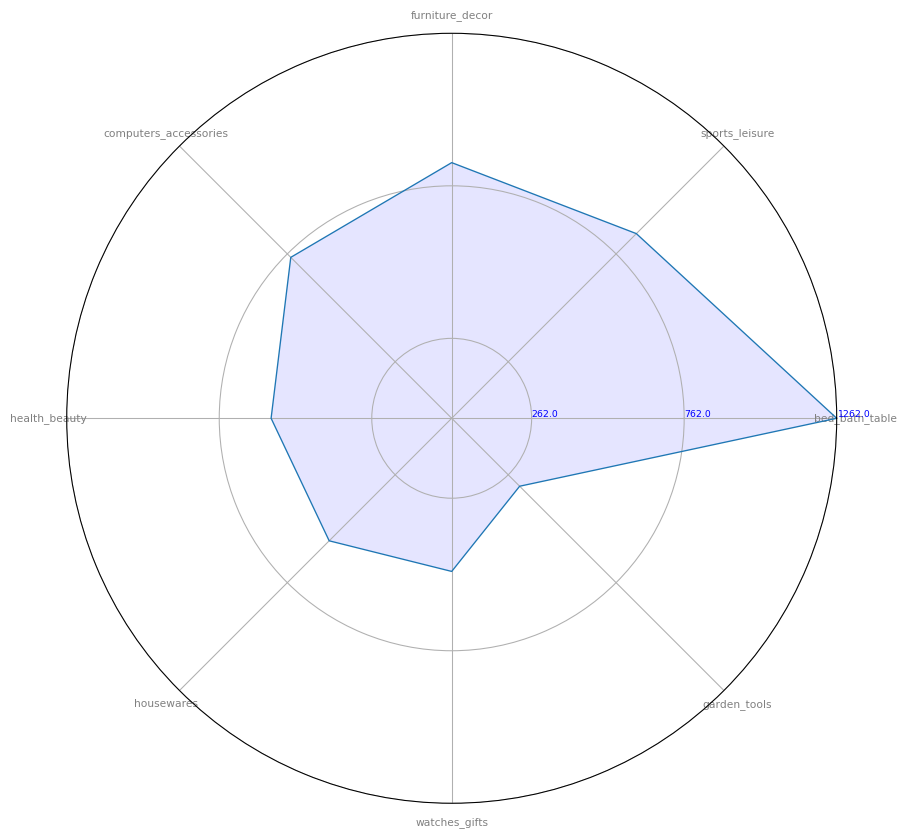

In [350]:
# Test pour 1 catégorie :

from math import pi


# number of variable
categories=list(Champions)[0:]
N = 8

# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=Champions.values.flatten().tolist()
values += values[:1]
values

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)   #111 : positionnement du graphe

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Draw ylabels

valmax=Champions.iloc[0].max()

ax.set_rlabel_position(0)
plt.yticks([valmax,valmax-500,valmax-1000,valmax-1500], [str(valmax),str(valmax-500),str(valmax-1000),str(valmax-1500)], color="blue", size=7)
plt.ylim(0,valmax)

# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

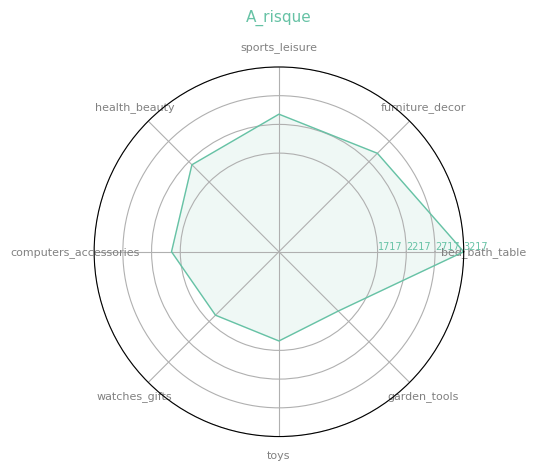

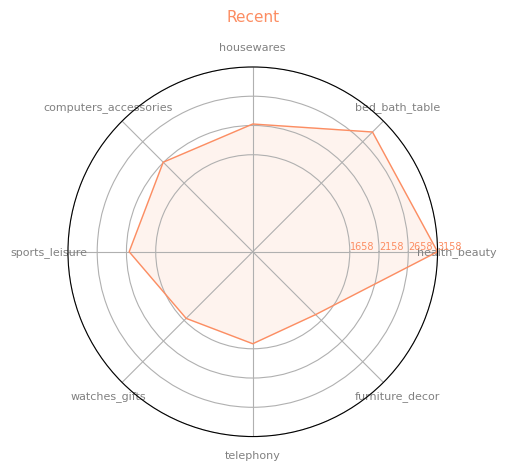

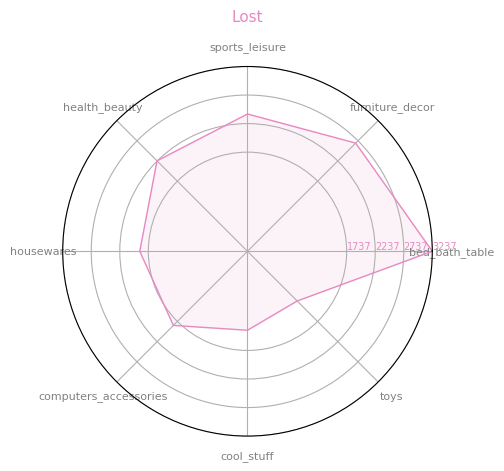

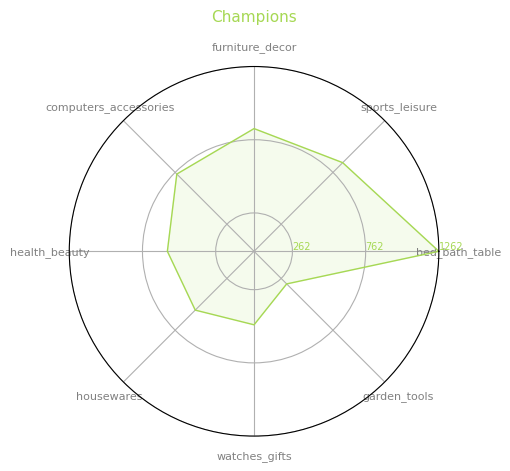

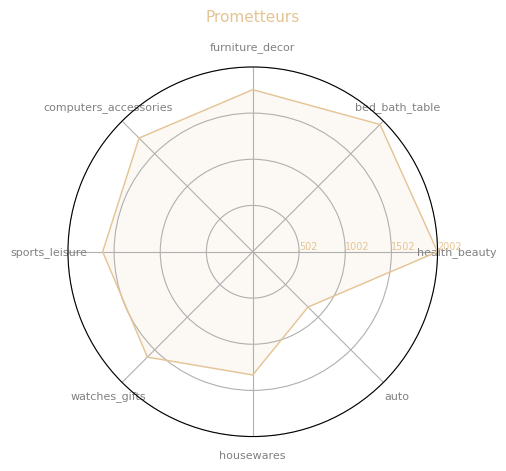

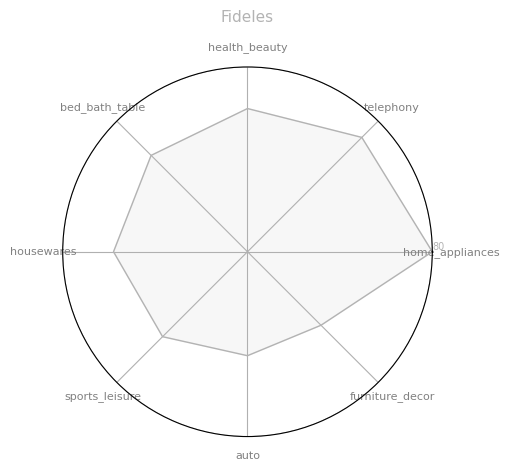

In [378]:

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", 6)
a=0


for cat in liste_df_2 :

    # number of variable
    categories=list(cat)[0:]
    N = 8

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=cat.values.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)   #111 : positionnement du graphe

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels

    valmax=round(cat.iloc[0].max())

    ax.set_rlabel_position(0)
    plt.yticks([valmax,valmax-500,valmax-1000,valmax-1500], [str(valmax),str(valmax-500),str(valmax-1000),str(valmax-1500)],rotation=90, color=my_palette(a), size=7)
    plt.ylim(0,valmax)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid', color=my_palette(a))

    # Fill area
    ax.fill(angles, values, color=my_palette(a), alpha=0.1)
    
    # Add a title
    plt.title(label=Title[a], size=11, color=my_palette(a), y=1.1)
    

    # Show the graph
    plt.show()
    
    a=a+1


In [380]:
df_customer_unique_id2.shape

(118837, 125)

In [458]:
df_customer_unique_id3.to_csv('P5_Modelisation.csv')